In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.image as mpimg
import preprocess_csv as psv
import importlib
importlib.reload(psv)
import time


# figures properties
sns.set_context('talk')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.bbox'] = 'tight'


In [141]:

# dpi = 300
plot_path = Path('../results/figures/') / time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())
Path(plot_path).mkdir(parents=True, exist_ok=True)


In [142]:
preprocess_data = True
if preprocess_data: # don't run this unless you want to preprocess the data again

    # preprocess data: concatenate all the data from all the monkeys, dates and experiments
    # renames the variables to be insync with the paper
    # removes the date and runs from the data which estimated offline fixation rate were lower 
    # than 89% (see paper for details)
    # saves the data in ../results/data/df_all.csv

    data_path = Path(f'../results/data/')
    df_all = psv.concat_data(data_path)
    df_all = psv.removeInvalidData(df_all)

else:
    # load the preprocessed data
    df_all = pd.read_csv('../results/data/df_all.csv')

In [143]:
df_r = df_all.groupby(['exp_name','monkey',  'run', 'date']).mean().reset_index().groupby(['exp_name','monkey']).count()
df_r = df_r.iloc[:, :1]
print(df_r.reset_index().to_markdown())

|    | exp_name   | monkey   |   run |
|---:|:-----------|:---------|------:|
|  0 | Expt. 1    | G        |    32 |
|  1 | Expt. 1    | N        |    39 |
|  2 | Expt. 1    | O        |    38 |
|  3 | Expt. 2    | H        |    37 |
|  4 | Expt. 2    | J        |    35 |
|  5 | Expt. 3    | H        |    32 |
|  6 | Expt. 3    | J        |    34 |


|    | exp_name   | monkey   |   run |
|---:|:-----------|:---------|------:|
|  0 | Expt. 1    | G        |    32 |
|  1 | Expt. 1    | N        |    39 |
|  2 | Expt. 1    | O        |    38 |
|  3 | Expt. 2    | H        |    37 |
|  4 | Expt. 2    | J        |    35 |
|  5 | Expt. 3    | H        |    32 |
|  6 | Expt. 3    | J        |    34 |

### 1. Ploting valid signal
- Percent of valid eye-data after removing the blinks and other artifacts 

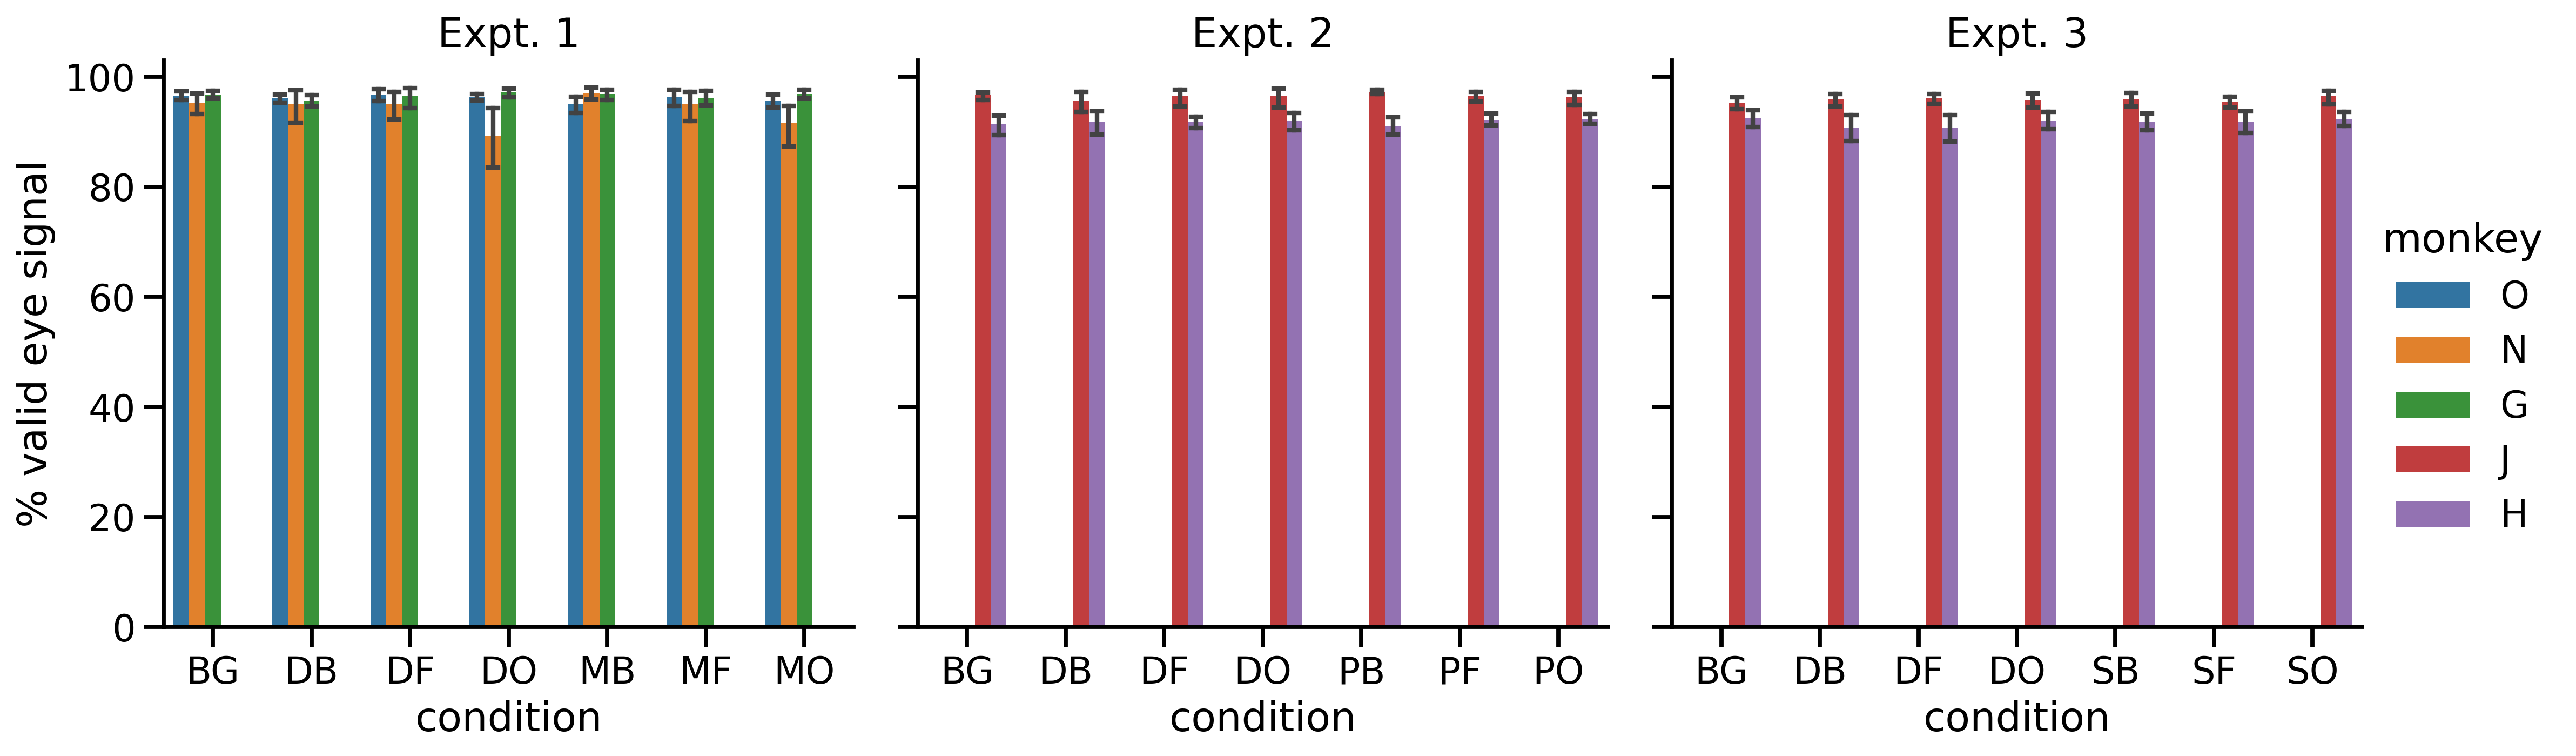

In [144]:
mnk_order = ['O', 'N', 'G', 'J', 'H']
df_svdata = df_all.groupby(['condt', 'run', 'monkey', 'exp_name']).mean()[
    'srv_perc'].reset_index()
df_svdata['srv_perc'] = df_svdata.srv_perc*100

fg = sns.catplot(data=df_svdata, x='condt', y='srv_perc', hue='monkey',
 col='exp_name', kind='bar', errwidth=2, capsize=.1, sharex=False,
 hue_order=mnk_order, height=5, aspect=1)

fg.set_axis_labels('condition', '% valid eye signal')
fg.set_titles('{col_name}')
fg.savefig( plot_path / 'srv_perc.png')

### 2. Fixation ratio
 - The data for experiment-3 were estimated offine

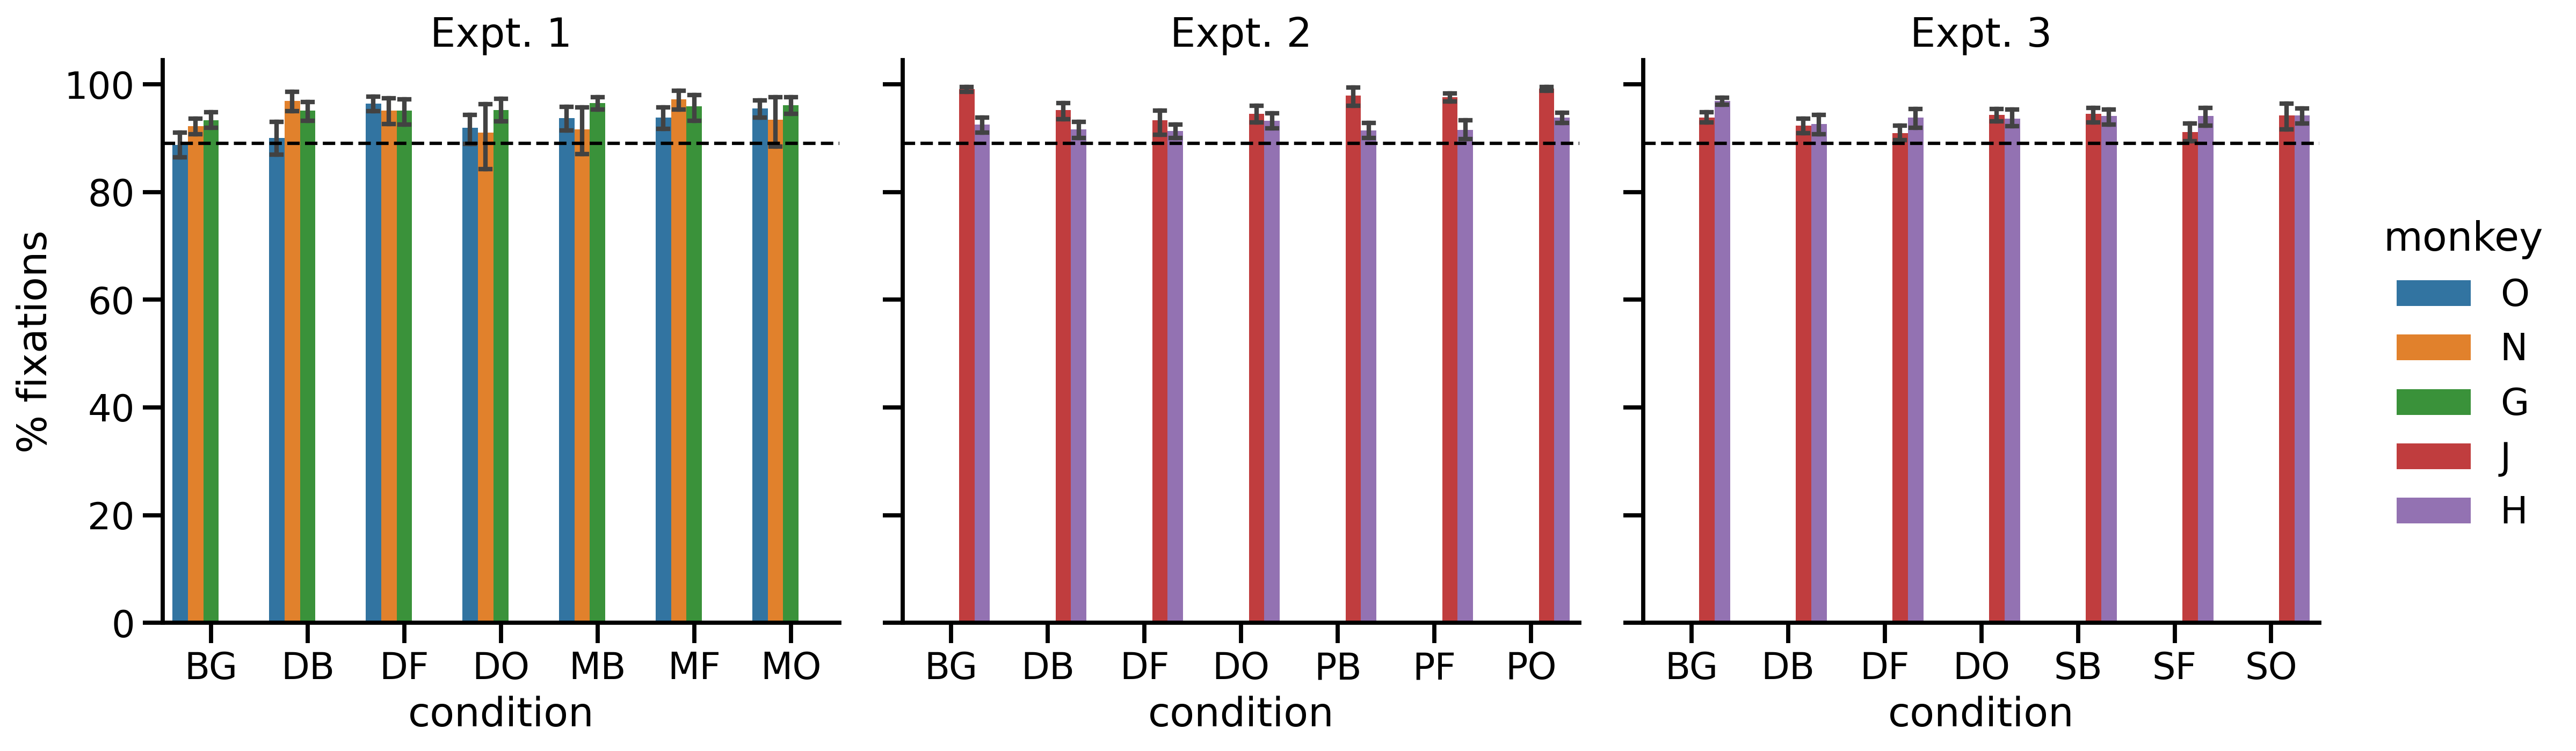

In [ ]:
df_fixdata = df_all.groupby(['condt', 'run', 'monkey', 'exp_name']).mean()[
    'fixPerc_condt'].reset_index()

fg = sns.catplot(data=df_fixdata, x='condt', y='fixPerc_condt', hue='monkey',
 col='exp_name', kind='bar', errwidth=2, capsize=.1, sharex=False,
 hue_order=mnk_order, height=5, aspect=1)

fg.set_axis_labels('condition', '% fixations')
fg.refline(y=89, color='k', linewidth=1.5)
fg.set_titles('{col_name}')
fg.savefig(plot_path / 'fix_perc.png')


### 3. Fixation contour 

In [ ]:

def plotCountour(data = None, x=None, y=None, **kwargs):
    '''funtion to plot contour line at the 25% level of the nomalized 2-d histogram'''

    xdata = data[x]
    ydata = data[y]

    nbins = 50
    c_extent = 3
    xedges = np.linspace(-c_extent, c_extent, nbins)
    yedges = np.linspace(-c_extent, c_extent, nbins)
    levels = [25]
    # map color to ncodt

    # df_mnk_expt_condt = df_mnk_expt.query('condt == @icondt')
    hval, _, _ = np.histogram2d(xdata, ydata, bins=[xedges, yedges])
    hval = hval.T
    hval = (hval/hval.max())*100
    # plot contour lines with color map
    CS = plt.contour(xedges[:-1], yedges[:-1], hval, levels = levels)
    
    p = CS.collections[0].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    y = v[:,1]
    plt.plot(x, y, linewidth=2, **kwargs)

In [ ]:
def fix_order(df_expt):
    ''' function to return the order of the conditions in the experiment'''
    
    exp_order = df_expt.condt.unique().tolist()
    exp_order.sort()

    if df_expt.exp_name.unique() == 'Expt. 1':
        mnk_order = ['O', 'N', 'G']
    else:
        mnk_order = ['H', 'J']
    return exp_order, mnk_order

In [ ]:
# get qureis for each monkey and experiment
# df_mnk_expt= df_all.query('monkey == "H" & exp_name == "Expt. 3"')
df_expt_1 = df_all.query('exp_name == "Expt. 1"')
df_expt_2 = df_all.query('exp_name == "Expt. 2"')
df_expt_3 = df_all.query('exp_name == "Expt. 3"')

In [ ]:
def plotExpCnt(df_expt):
    ''' function to faceted conotur plot the eye data for each experiment'''
    
    condt_order, mnk_order = fix_order(df_expt)
    if df_expt.exp_name.unique()[0] == 'Expt. 1':
        mnk_order = ['O', 'N', 'G']
    else:
        mnk_order = ['J', 'H']
    condt_order.append(condt_order.pop(condt_order.index('DB')))
    g1 = sns.FacetGrid(df_expt, col='monkey', hue='condt',
    hue_order = condt_order, col_order=mnk_order, height=5, aspect=0.9)
    g1.map_dataframe(plotCountour, x='xdata', y='ydata')
    g1.set_titles(col_template='{col_name}', row_template='{row_name}')
    g1.set(xlabel='x ($\degree$)', ylabel='y ($\degree$)', xticks=[-3, 0, 3], yticks=[-3, 0, 3])
    cond_order_res = np.sort(condt_order)
    g1.add_legend(label_order= cond_order_res)
    g1.legend.set_title(None)
    g1.fig.suptitle(f'{df_expt.exp_name.unique()[0]}')
    g1.tight_layout()
    g1.savefig(plot_path / f'contour_{df_expt.exp_name.unique()[0]}.png')
    return g1

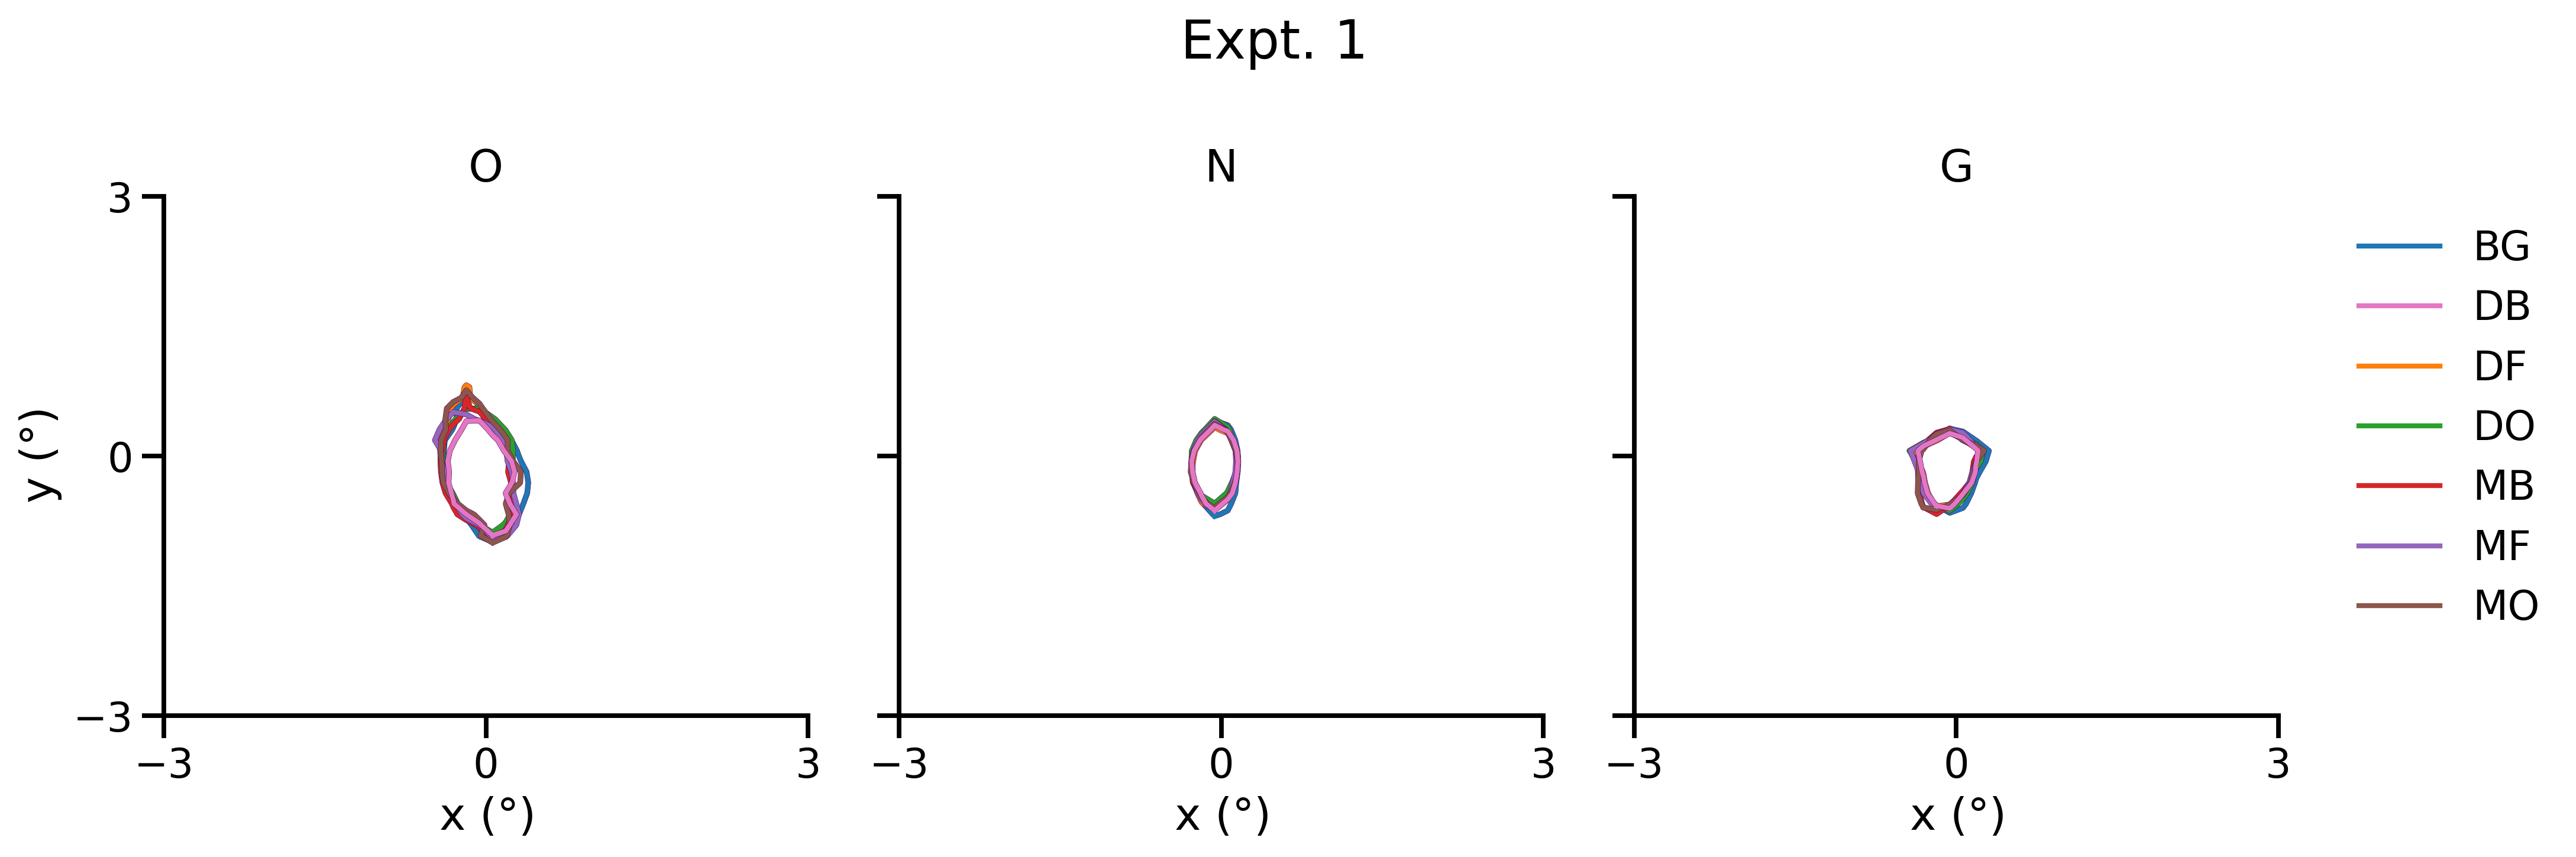

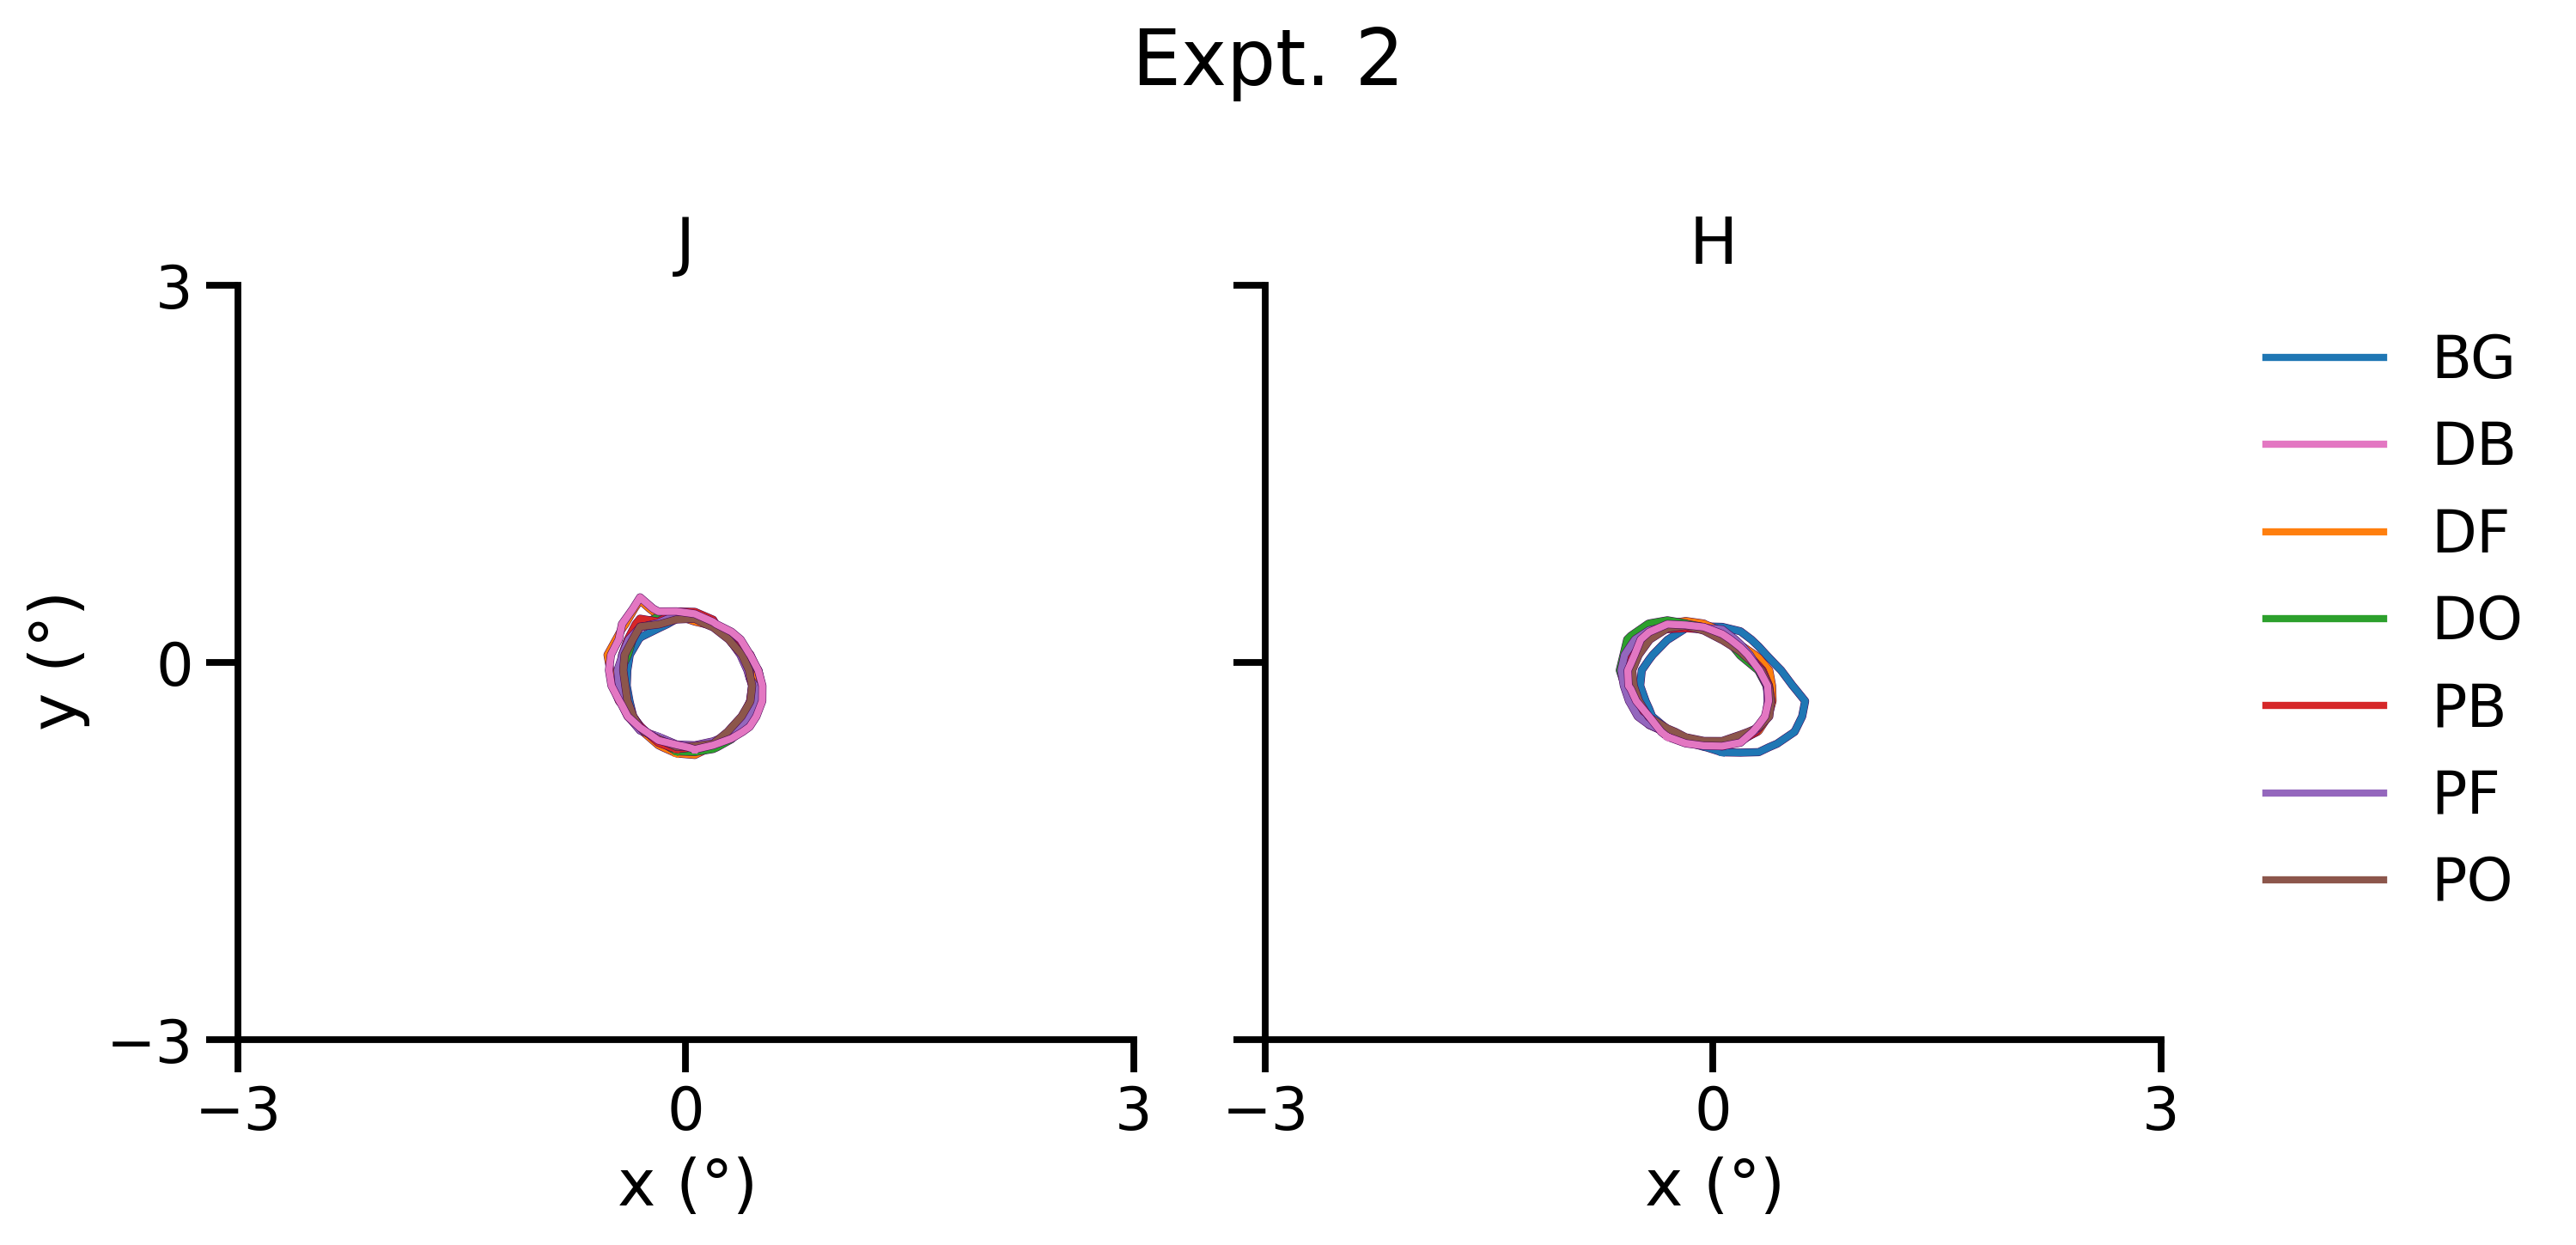

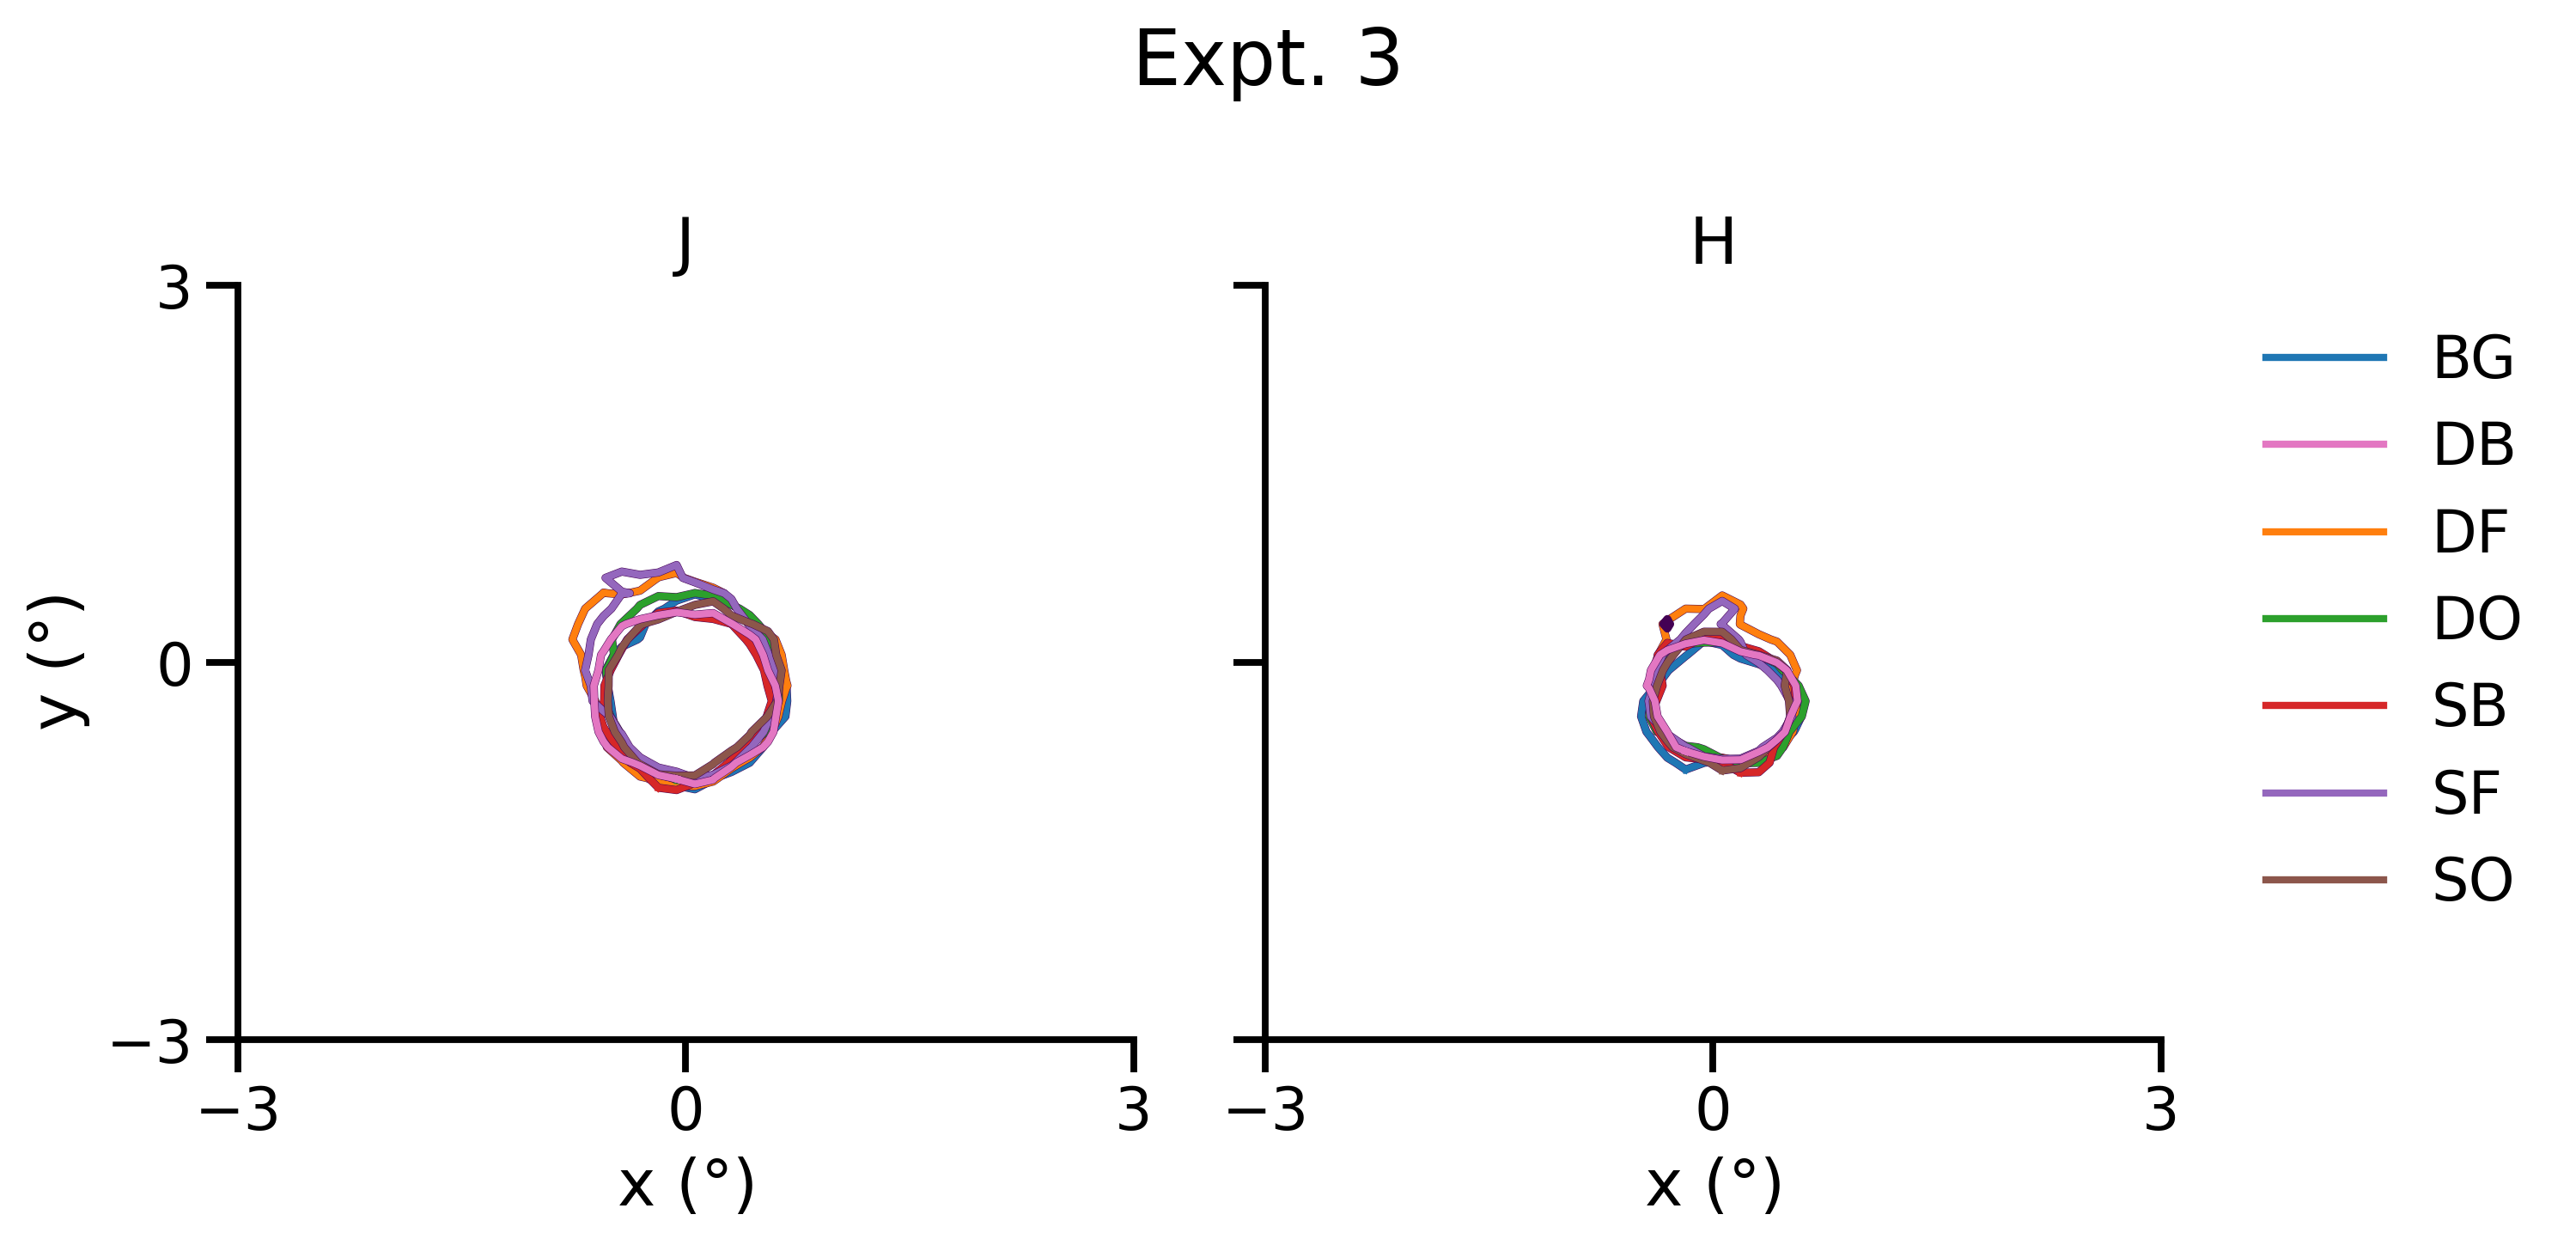

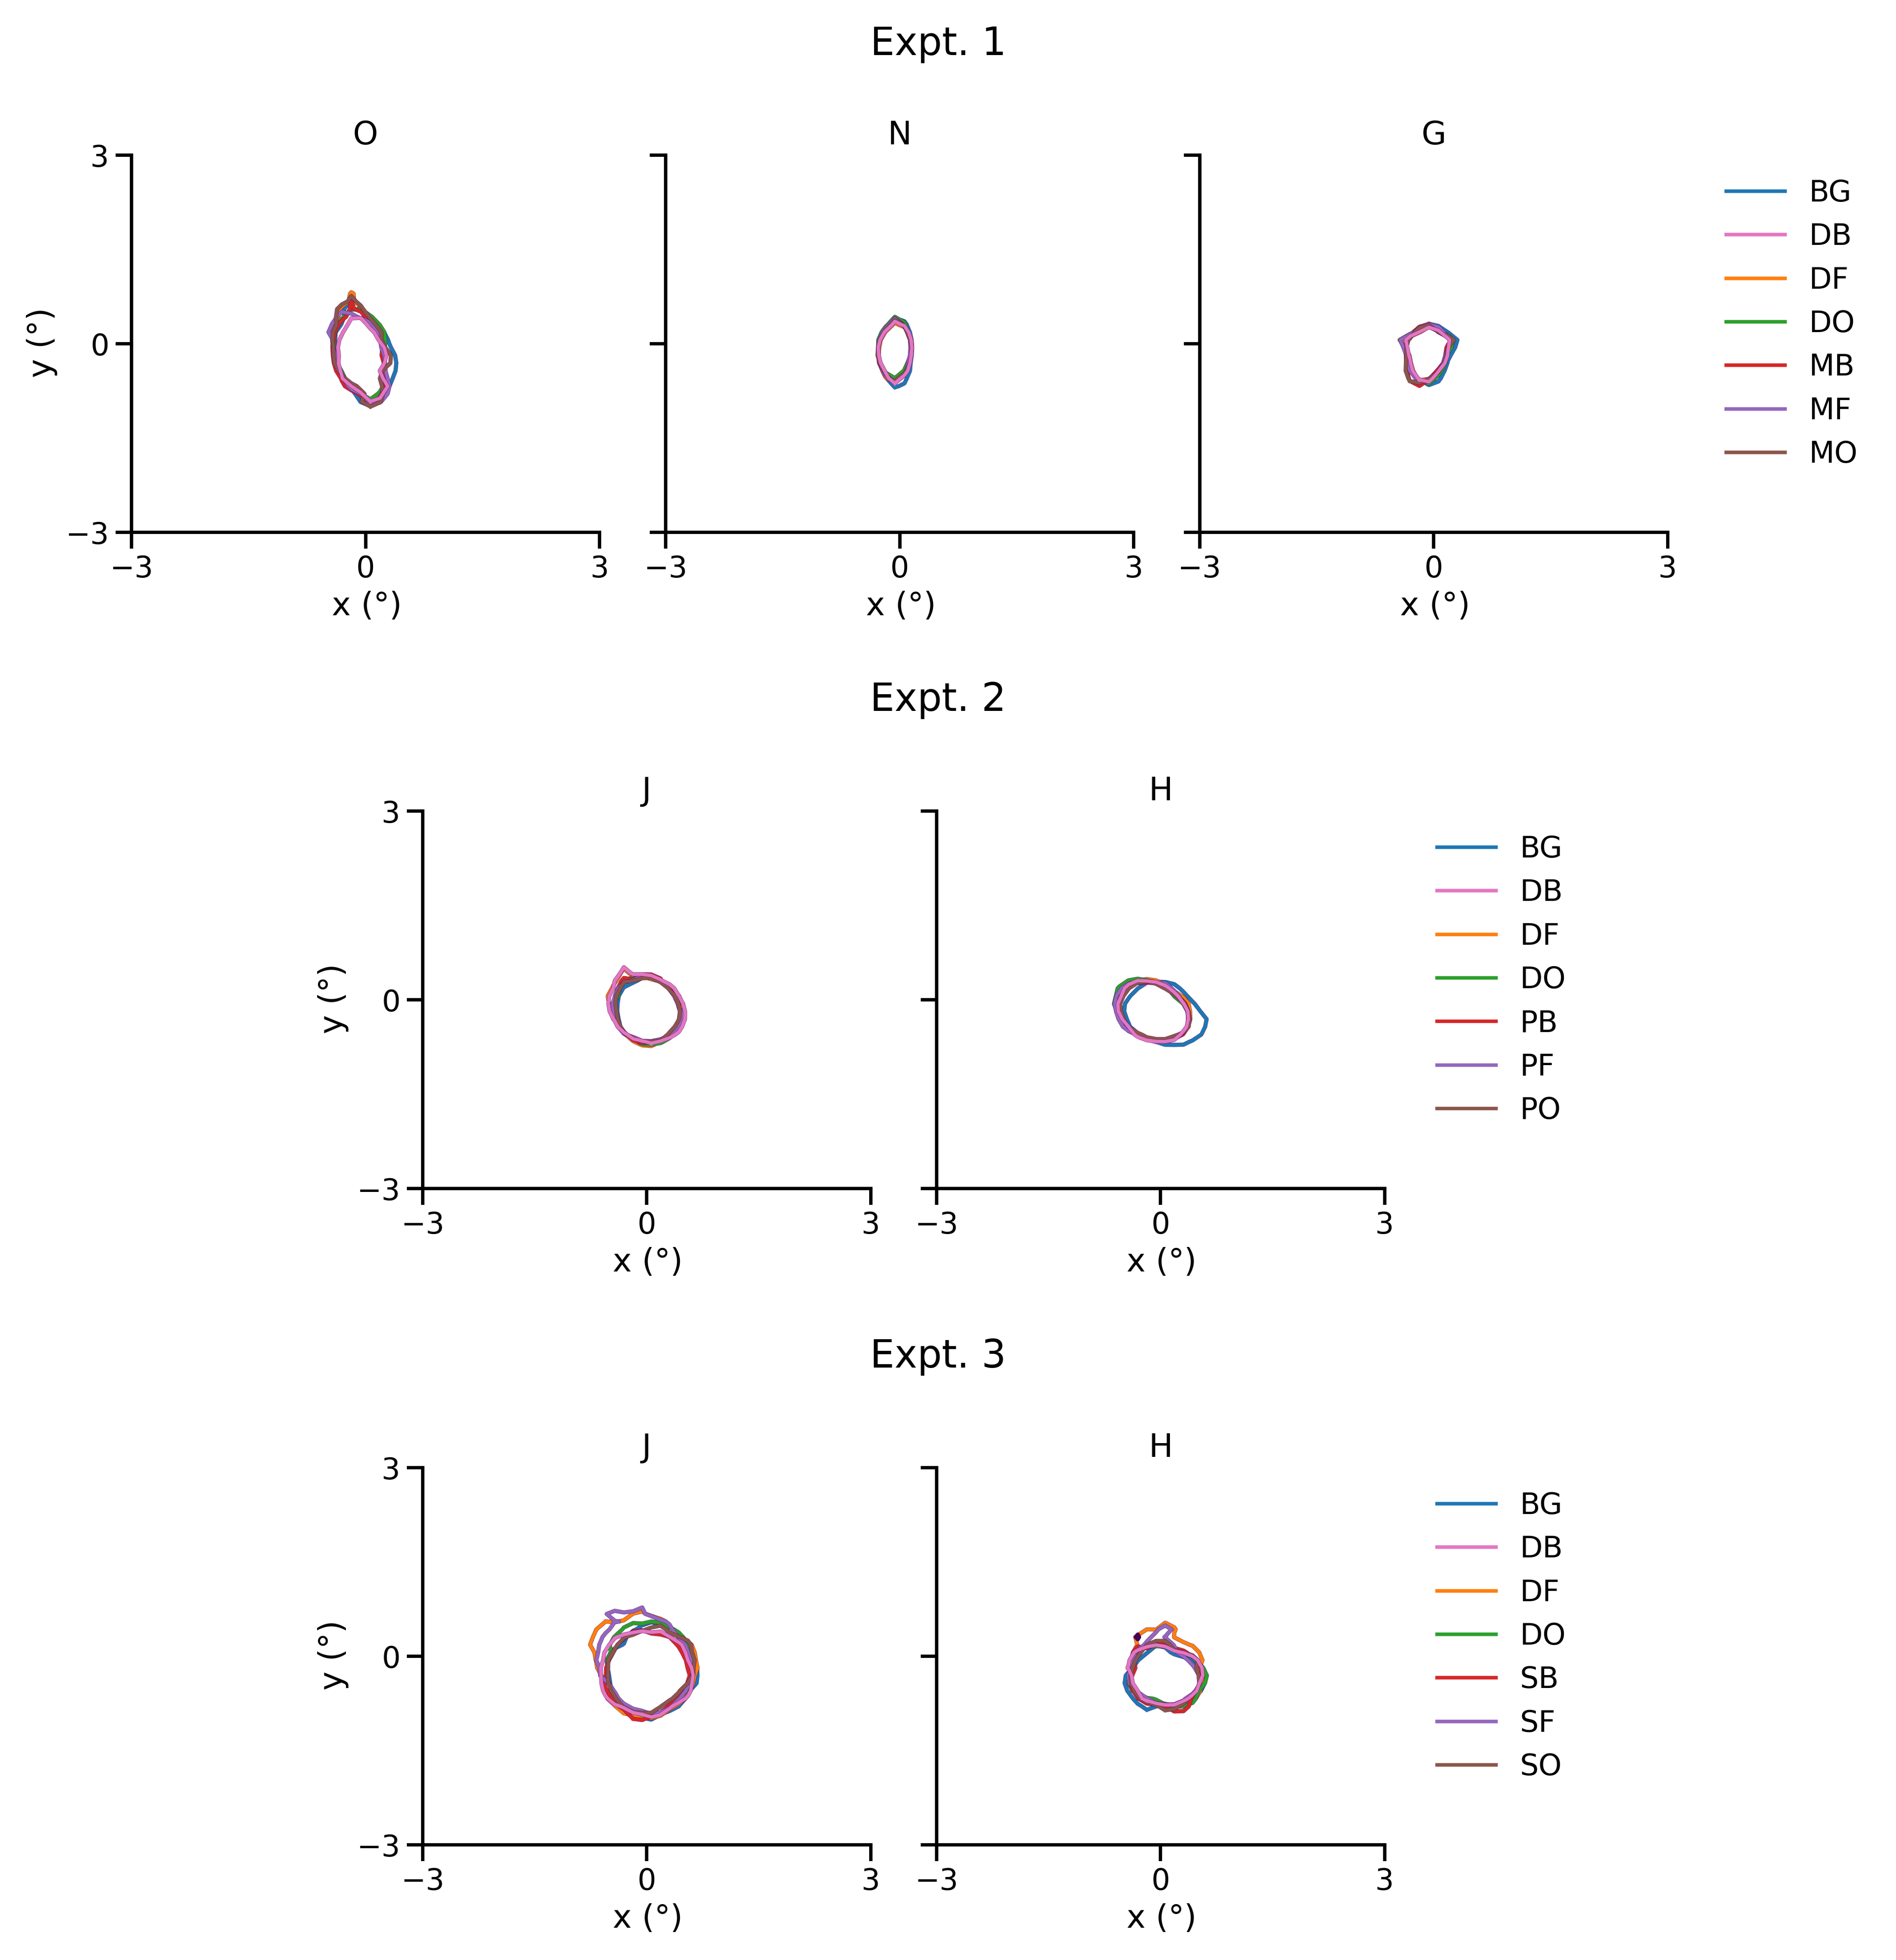

In [ ]:
g1 = plotExpCnt(df_expt_1)
g2 = plotExpCnt(df_expt_2)
g3 = plotExpCnt(df_expt_3)

# using mpimg to read the images and combine them in a single figure
fig, axarr = plt.subplots(3, 1, figsize=(25, 16))
axarr[0].imshow(mpimg.imread(plot_path / 'contour_Expt. 1.png'))
axarr[1].imshow(mpimg.imread(plot_path / 'contour_Expt. 2.png'))
axarr[2].imshow(mpimg.imread(plot_path / 'contour_Expt. 3.png'))
# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()
plt.show()
fig.savefig(plot_path / 'contour.png')

### 4. Saccade frequency
- Saccade: Eye movement faster than 10 $\degree$/s and larger than 3 $\degree$

In [ ]:
fs = 120
df_SCdata = df_all.query('sacc == 1') # selecting only saccade data
df_SCdata_cl = df_SCdata.copy()
df_SCdata_cl['vel_all'] = np.sqrt(df_SCdata_cl['Xvel']**2 + df_SCdata_cl['Yvel']**2)

# only saccades with velocity > 10 deg/s and distance > 0.2 deg
df_SCdata_cl = df_SCdata_cl[(df_SCdata_cl['vel_all'] > 10) & (
df_SCdata_cl['dist'] > 0.3)]

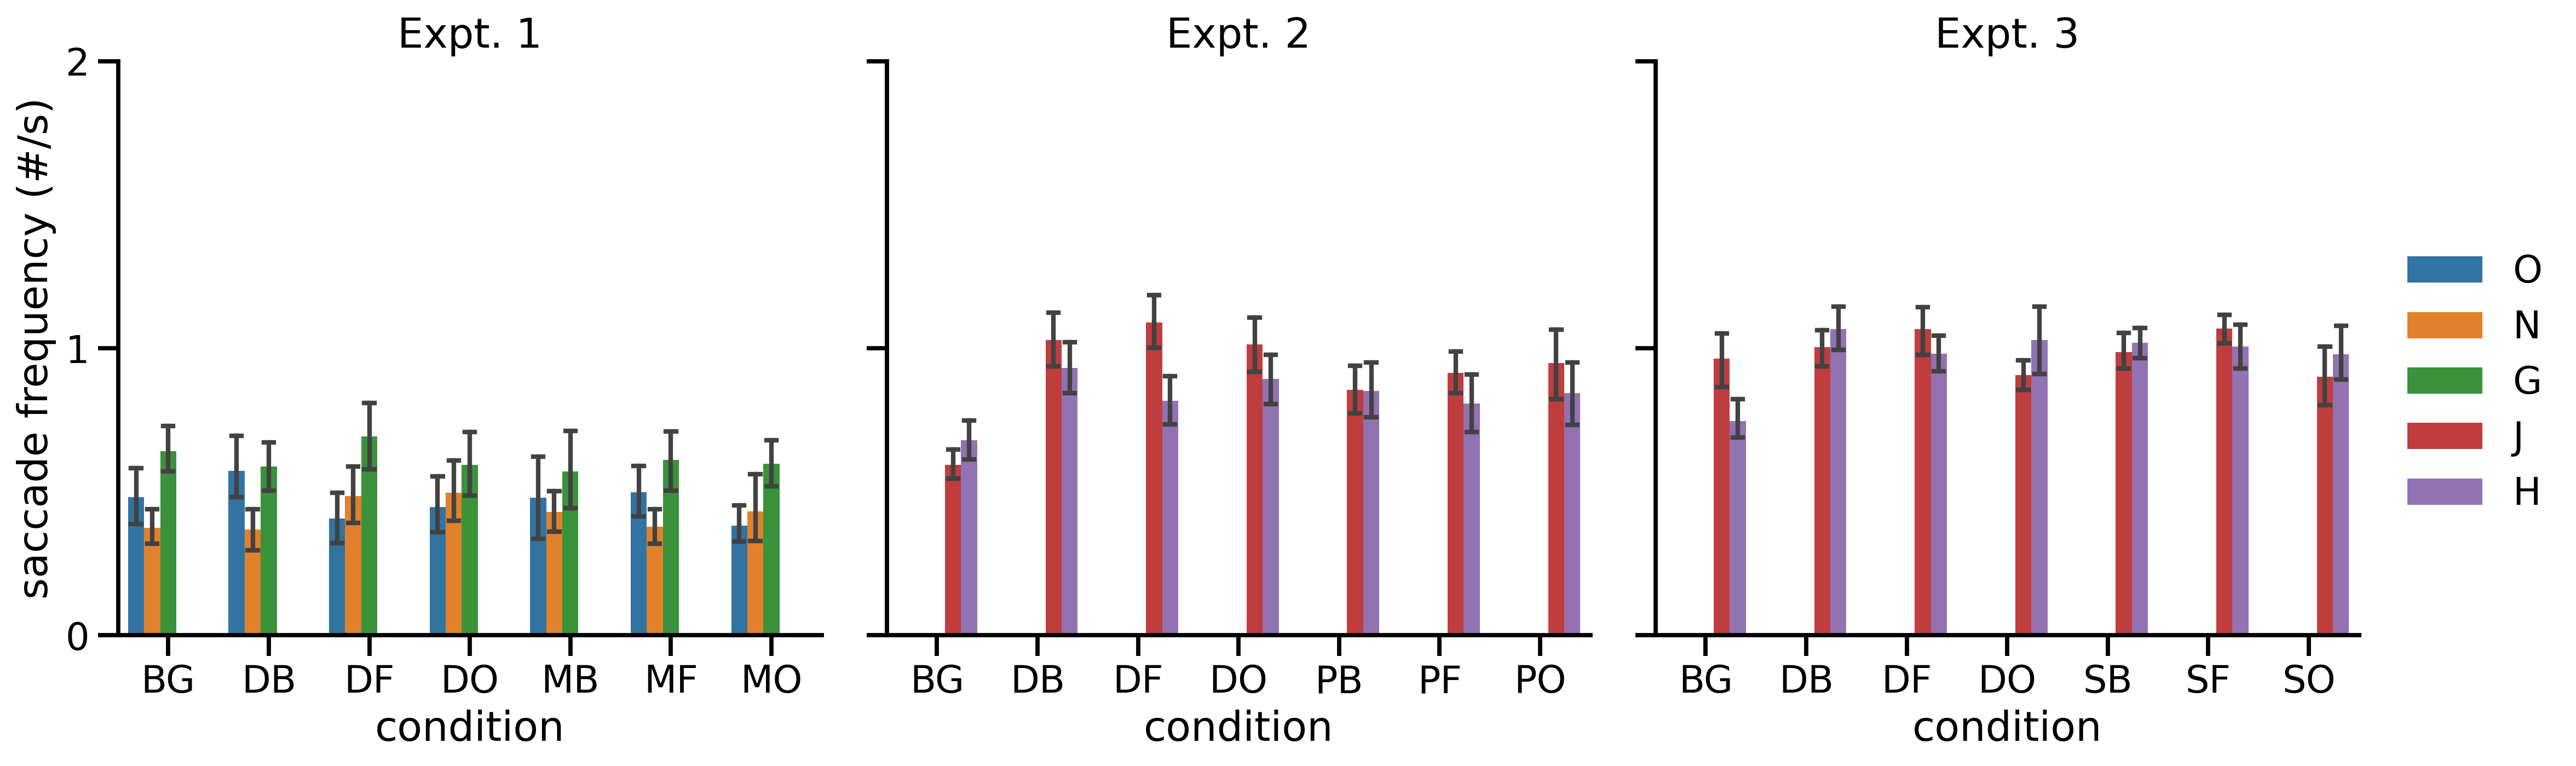

In [ ]:
df_sc = df_SCdata_cl.groupby(
['condt', 'run', 'monkey', 'exp_name']).count().reset_index()

# computing frequency of saccades per condi
srv_sec = df_all.groupby(['condt', 'run', 'monkey', 'exp_name']).count(
).reset_index().xdata*(1/fs)  # survived data in seconds
df_sc['freq'] = df_sc['Xvel'] / srv_sec  # frequency of saccades per second

fg = sns.catplot(data=df_sc, x='condt', y='freq', hue='monkey', col = 'exp_name',
sharex=False, kind='bar', errwidth=2, capsize=.1, hue_order=mnk_order, height=5, aspect=1)
fg.set_axis_labels('condition', 'saccade frequency (#/s)')
fg.set_titles('{col_name}')
fg.set(ylim=(0, 2), yticks=[0,  1, 2])
fg.legend.set_title(False)

plotRuns = False
if plotRuns:
    # code to add the number of runs for each monkey and experiments
    i = 0
    for iexp in df_r.index.get_level_values(0).unique():
        exp_val = df_r.loc(axis=0)[f'{iexp}'].to_dict()
        idx = 0
        for key in exp_val['run'].keys():
            n_run = exp_val['run'][key]
            fg.axes[0, i].annotate(f"n({key}) = {n_run}", xy=(0, 1-idx*0.1), xycoords="axes fraction",
                                xytext=(5, -5), textcoords="offset points",
                                ha="left", va="top")
            idx += 1
        i += 1

fg.savefig(plot_path / 'saccade_freq.png')

### 5. Saccade distance
- ploting median of the saccade amplitude

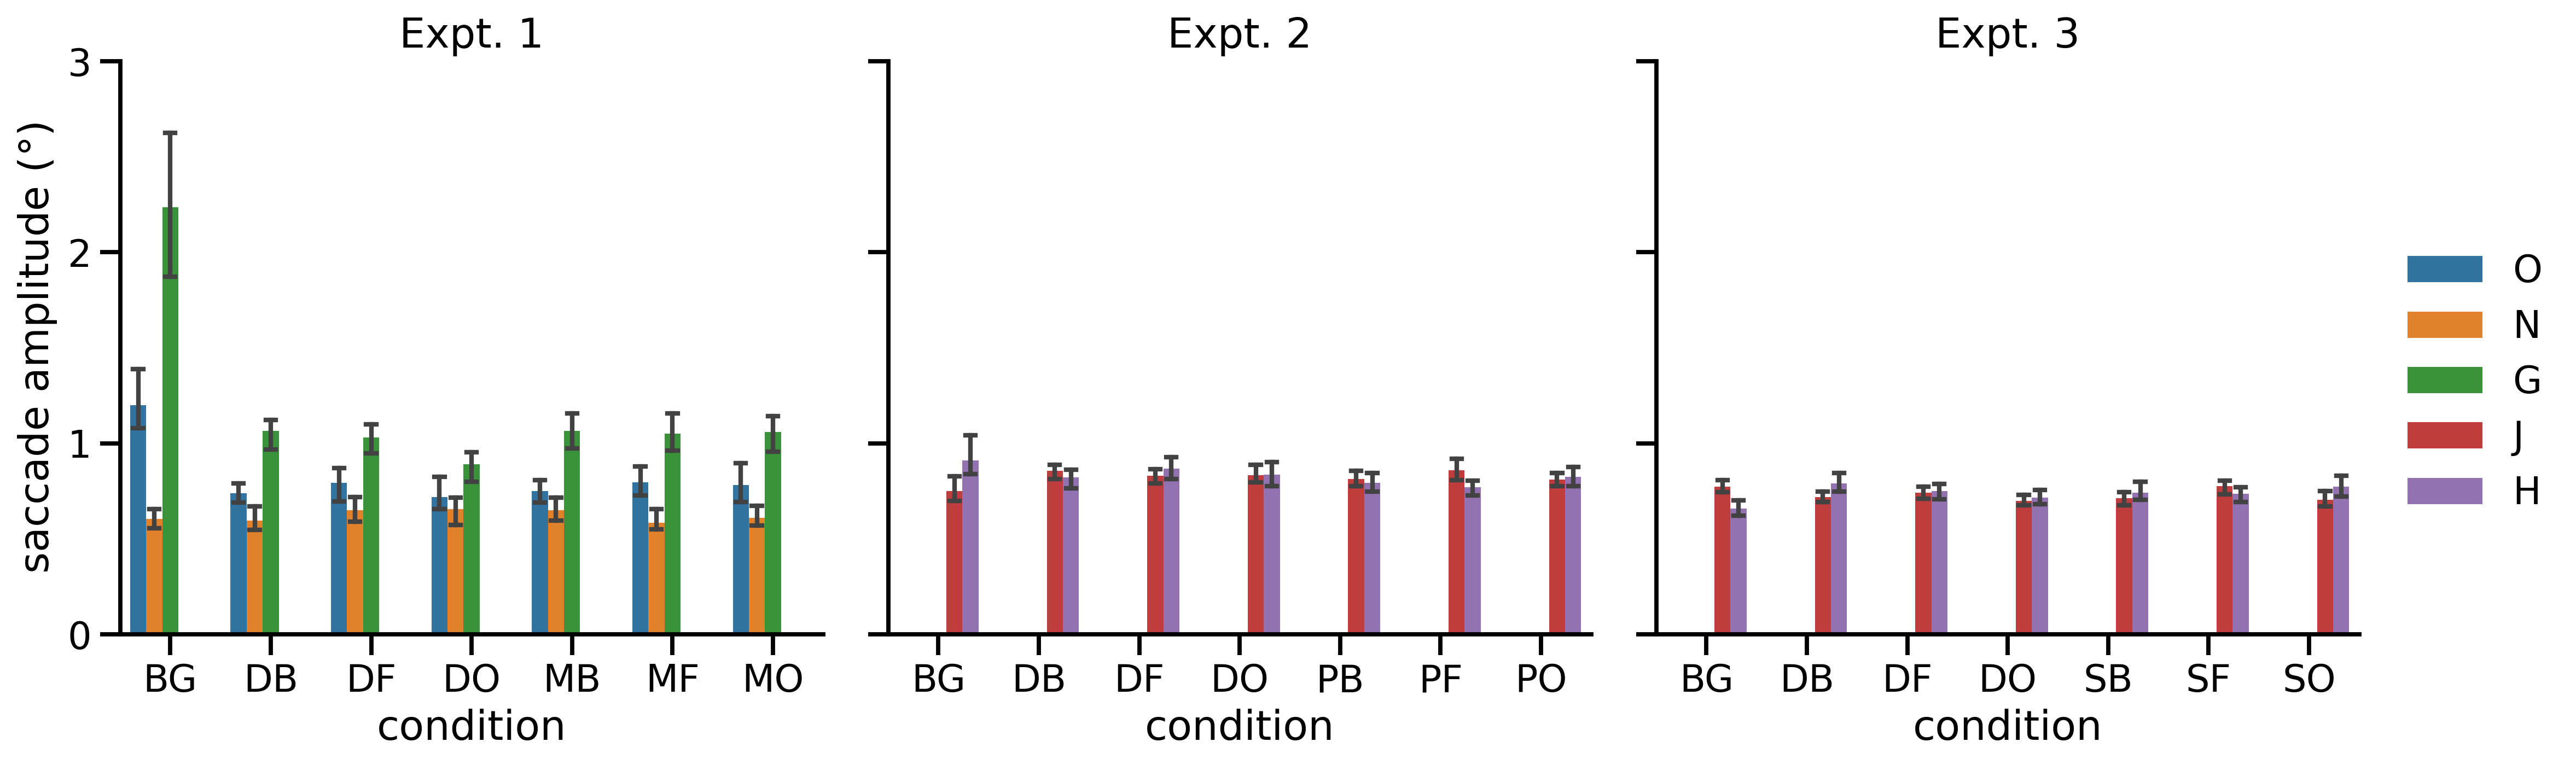

In [ ]:
df_sorted =df_SCdata_cl.sort_values('condt')
f = sns.catplot(data=df_sorted, x='condt', y='dist', hue='monkey', col = 'exp_name',
hue_order=mnk_order, col_order=['Expt. 1', 'Expt. 2', 'Expt. 3'],
 height=5, aspect=1, sharex=False, kind = "bar", estimator=np.median, errwidth=2, capsize=.1)

f.legend.set_title(False)
f.set_axis_labels('condition', 'saccade amplitude ($\degree$)')
f.set_titles('{col_name}')
f.set(ylim=(0, 2), yticks=[0,  1, 2, 3])
f.savefig(plot_path / 'saccade_dist.png')

### 6. Saccade direction 

In [ ]:
palette = sns.color_palette("tab10", 7)

# transforming saccade velocity from cartesian to polar coordinates 
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    # phi = np.arctan2(y, x)*(180/np.pi)
    return(rho, phi)

# including the velocity in polar coordinates in the dataframe
rho, phi = cart2pol(df_SCdata_cl.Xvel, df_SCdata_cl.Yvel)
df_SCdata_cl['rho'] = rho
df_SCdata_cl['phi'] = phi


# facetgrid maping function
def polarHist(degrees, **kwargs):
    # ran = range(0, 360, 20)
    # bins = np.deg2rad(ran)
    bins = np.linspace(-np.pi, np.pi, 20)
    bottom = 0
    radii, bins = np.histogram(degrees, bins=bins)
    N = len(bins)

    radii2 = radii/(radii.sum())
    radii3 = radii2 * 100
    width = (2*np.pi) / N

    ax = plt.bar(bins[:-1], radii3, zorder=1, align='edge',
                 width=width, alpha=0.8, fill=False,  bottom=bottom, **kwargs) # alpha value is important to have blank bars

    # transfering the facecolor to the edgecolor (to have a blank bar) 
    for patch in ax.patches: 
        clr = patch.get_facecolor()
        patch.set_edgecolor(clr)

    angle = np.deg2rad(67.5) #angle of the legend
    plt.legend(loc="lower left",
               bbox_to_anchor=(.5 + np.cos(angle)/2, .5 + np.sin(angle)/2))


In [ ]:
# plot the facetgrid for each experiment
def plotSaccadir(df_SCdata_cl):
    if df_SCdata_cl.exp_name.unique()[0] == 'Expt. 1':
        mnk_order = ['O', 'N', 'G']
    else:
        mnk_order = ['J', 'H']
    # mnk_order, _ = df_SCdata_cl.monkey.unique().tolist()
    condt_order, _ = df_SCdata_cl.condt.unique().tolist(), df_SCdata_cl.monkey.unique().tolist()
    condt_order.sort()
    g = sns.FacetGrid(df_SCdata_cl, col="monkey", hue='condt', 
                        subplot_kws=dict(projection='polar'), 
                        sharex=True, sharey=True, despine=False, margin_titles=True,
                        hue_order=condt_order,col_order=mnk_order, palette=palette, height=5, aspect=.9)

    g.map(polarHist, "phi")
    g.set_titles(col_template="{col_name}",
                    row_template="{row_name}")
    g.add_legend()
    g.legend.set_title(None)

    max_xi = []
    for ax in g.axes.ravel():
        max_xi.append(ax.get_ylim()[1])
        # print(max_xi)
    max_x = np.int32(max(max_xi))
    # print(max_x)

    for margin_title in g._margin_titles_texts:
        margin_title.set_position([1.20, 0.5])

    g.set(xlabel=' ', rticks=[0, max_x],
            xticks=[0, np.pi/2, np.pi, 3*np.pi/2],

            yticklabels=[f'{0}%', f'{max_x}%'])
            
    g.tight_layout()
    g.fig.suptitle(f'{df_SCdata_cl.exp_name.unique()[0]}')
    g.savefig( plot_path /  f'saccade_dir_{df_SCdata_cl.exp_name.unique()[0]}.png')
    return g

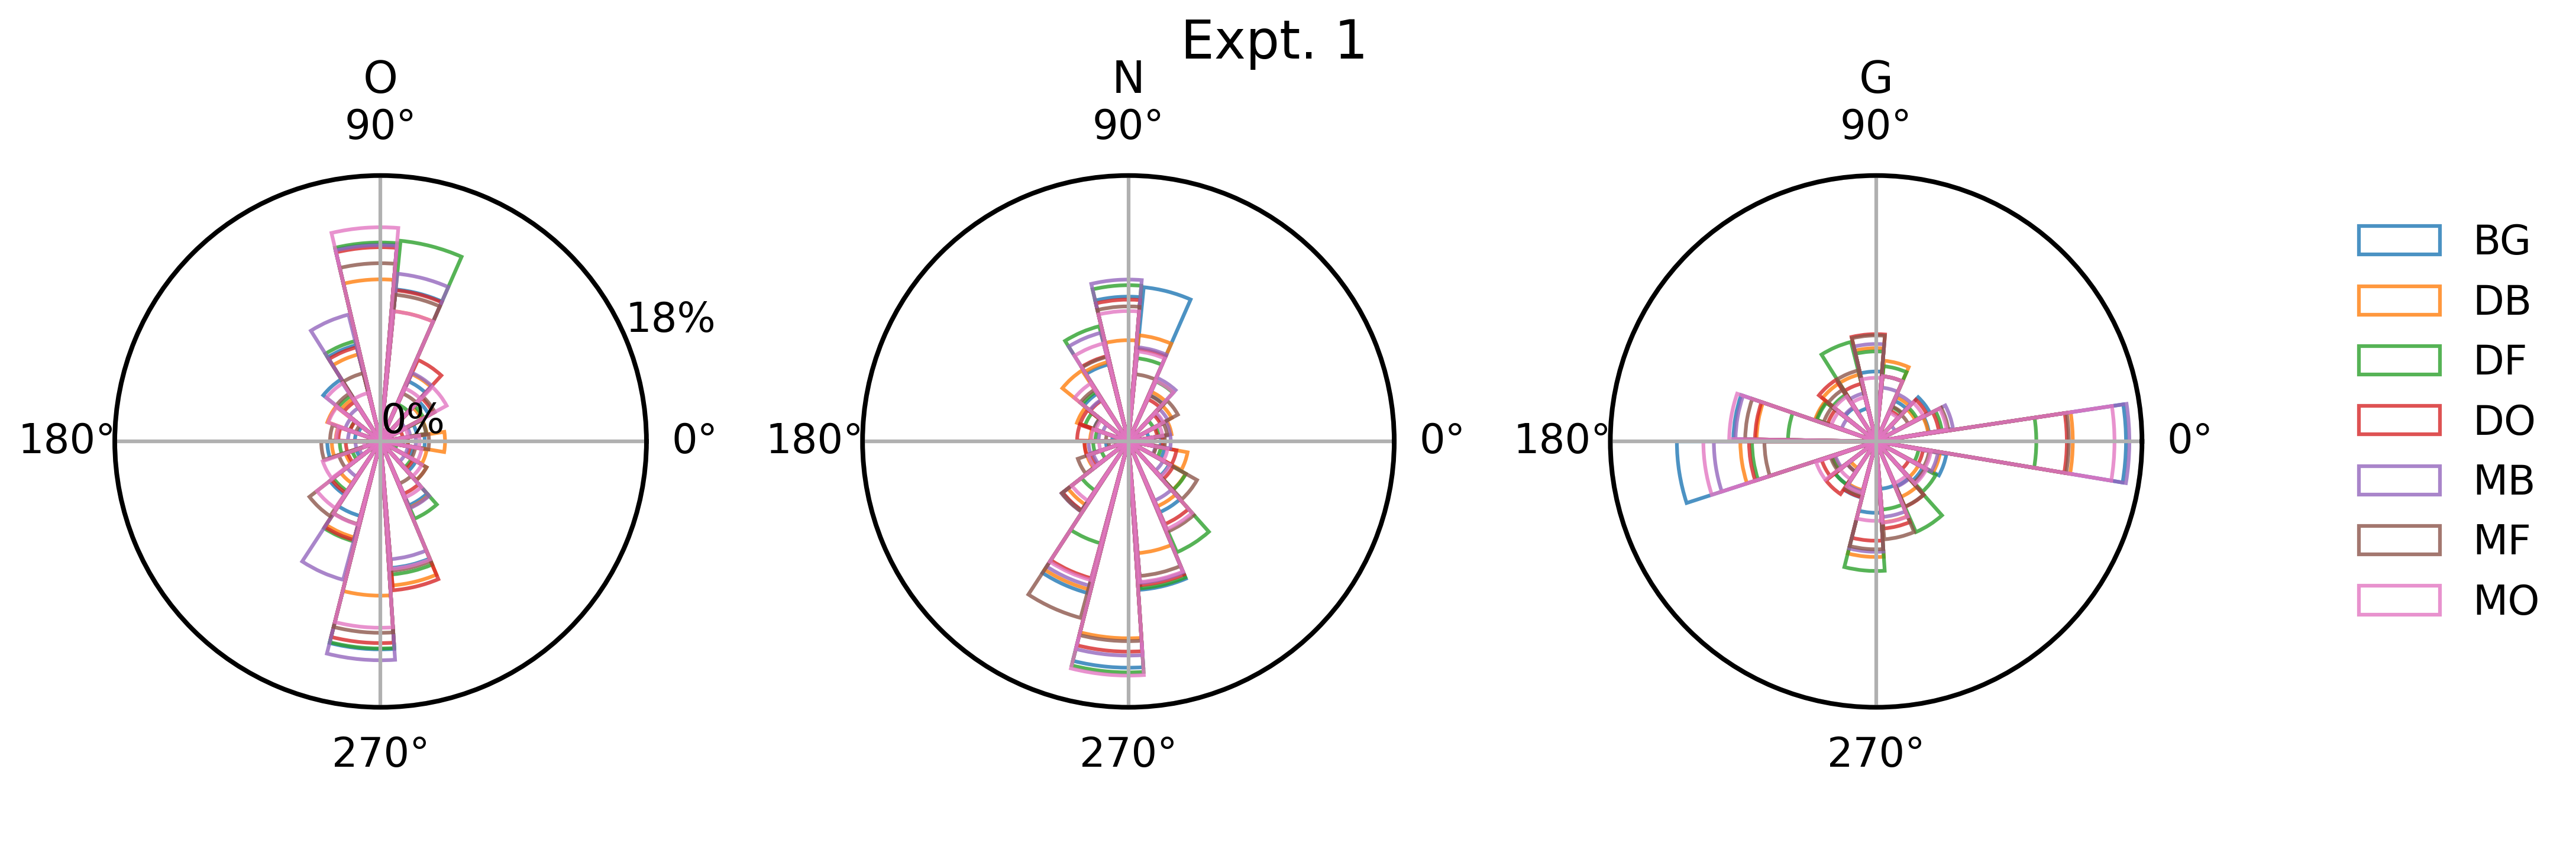

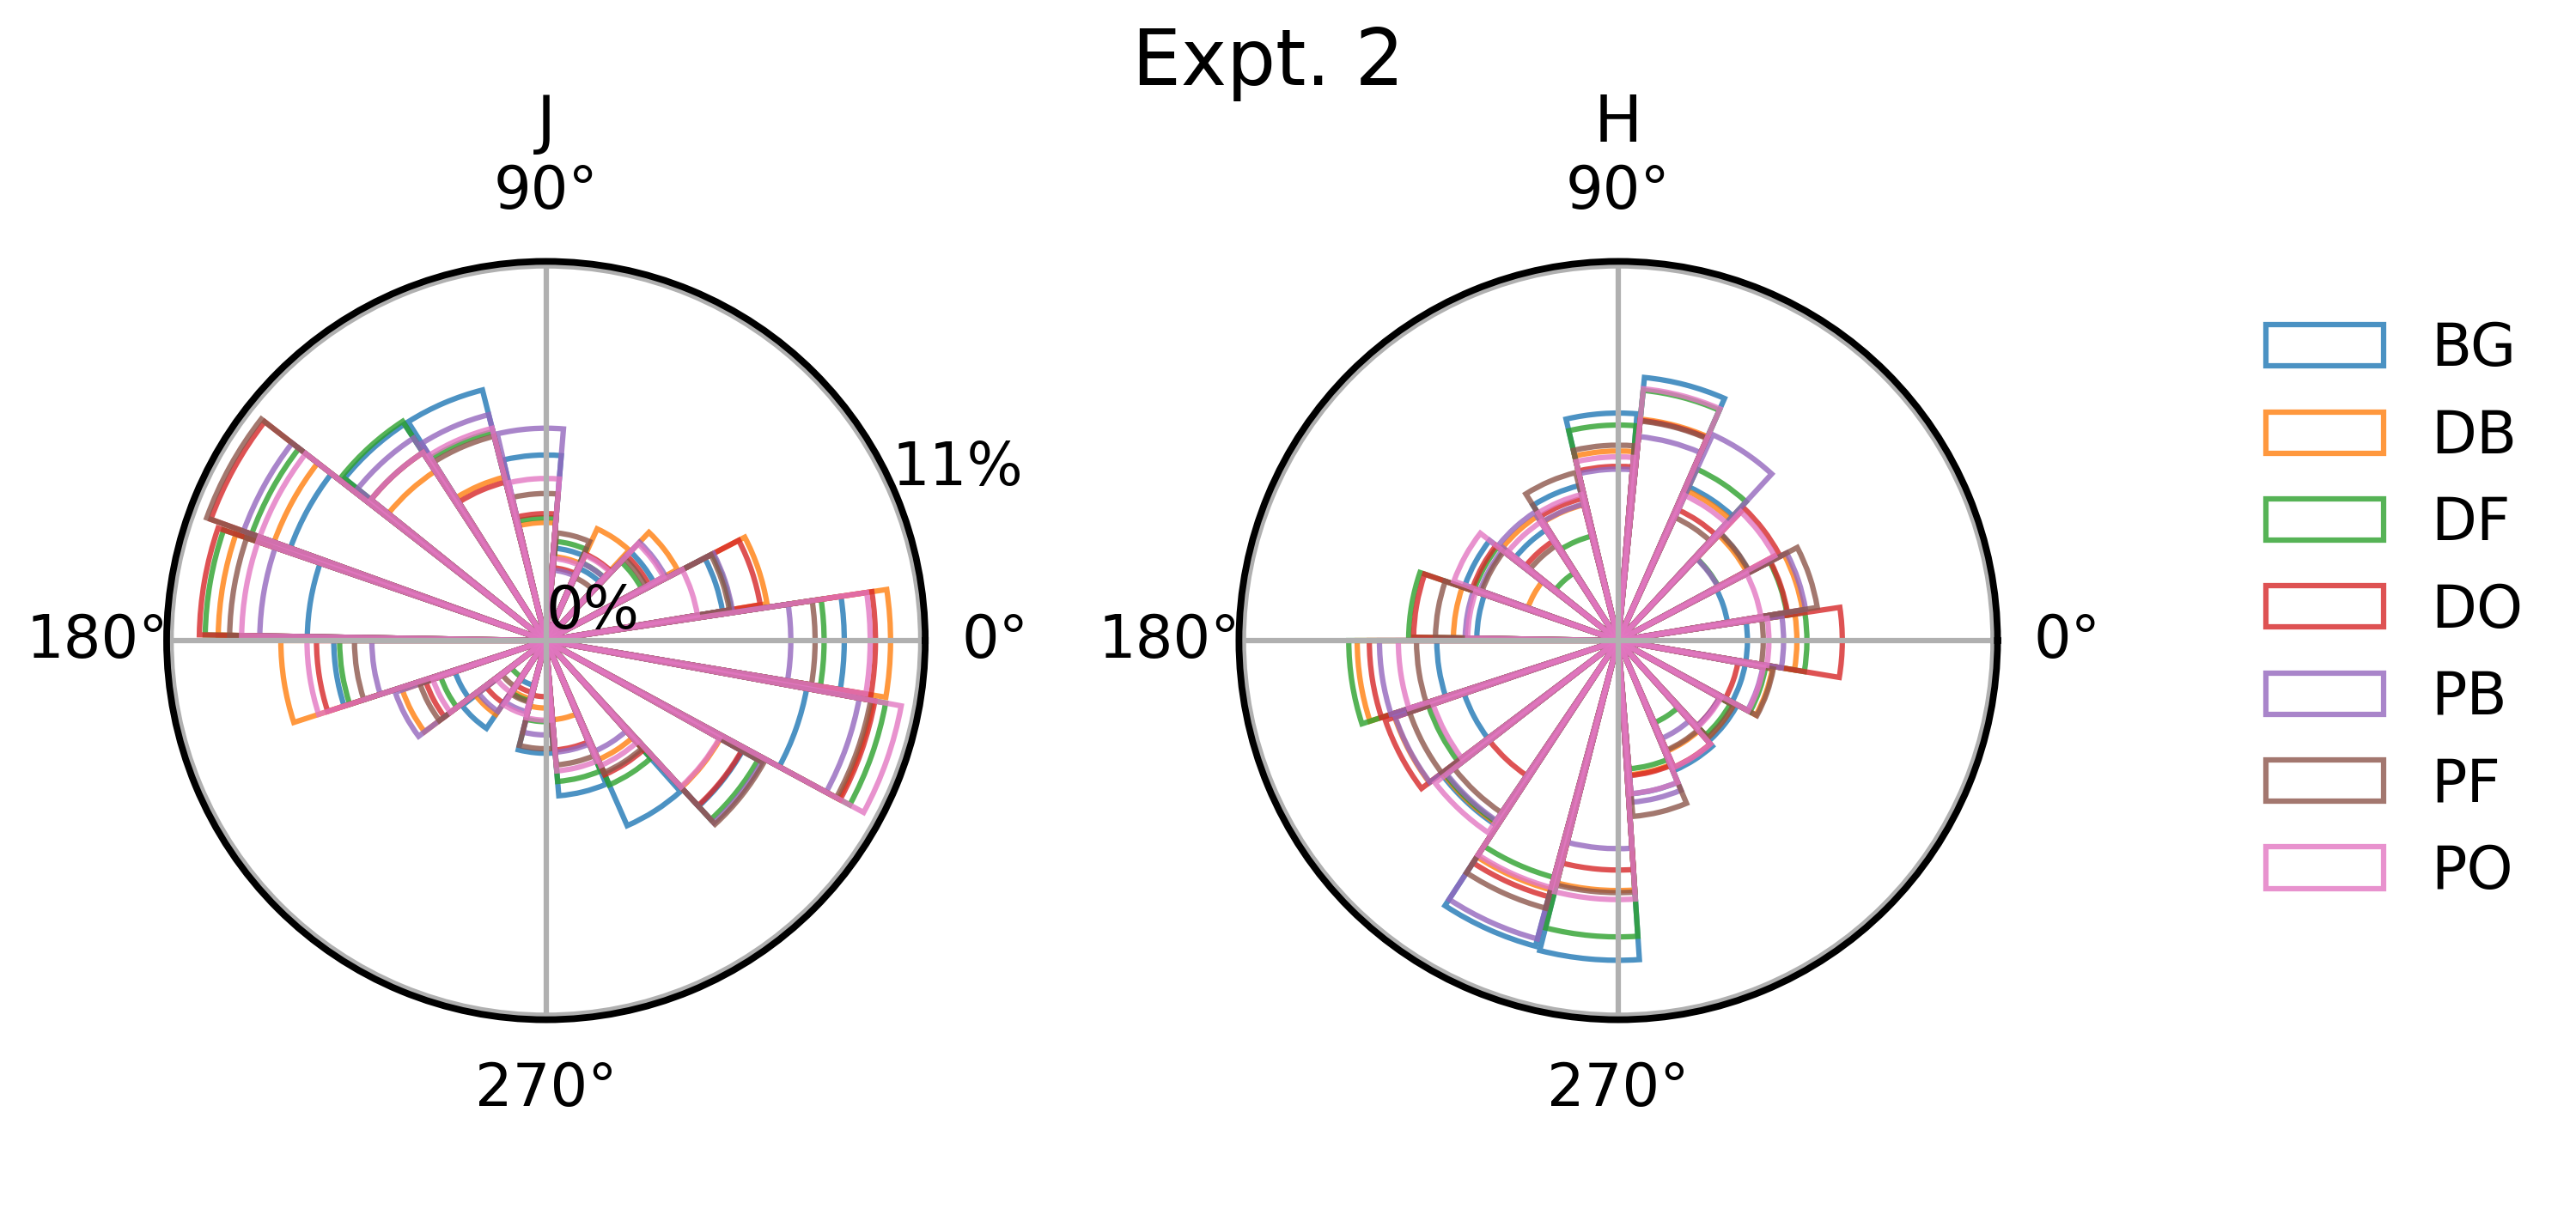

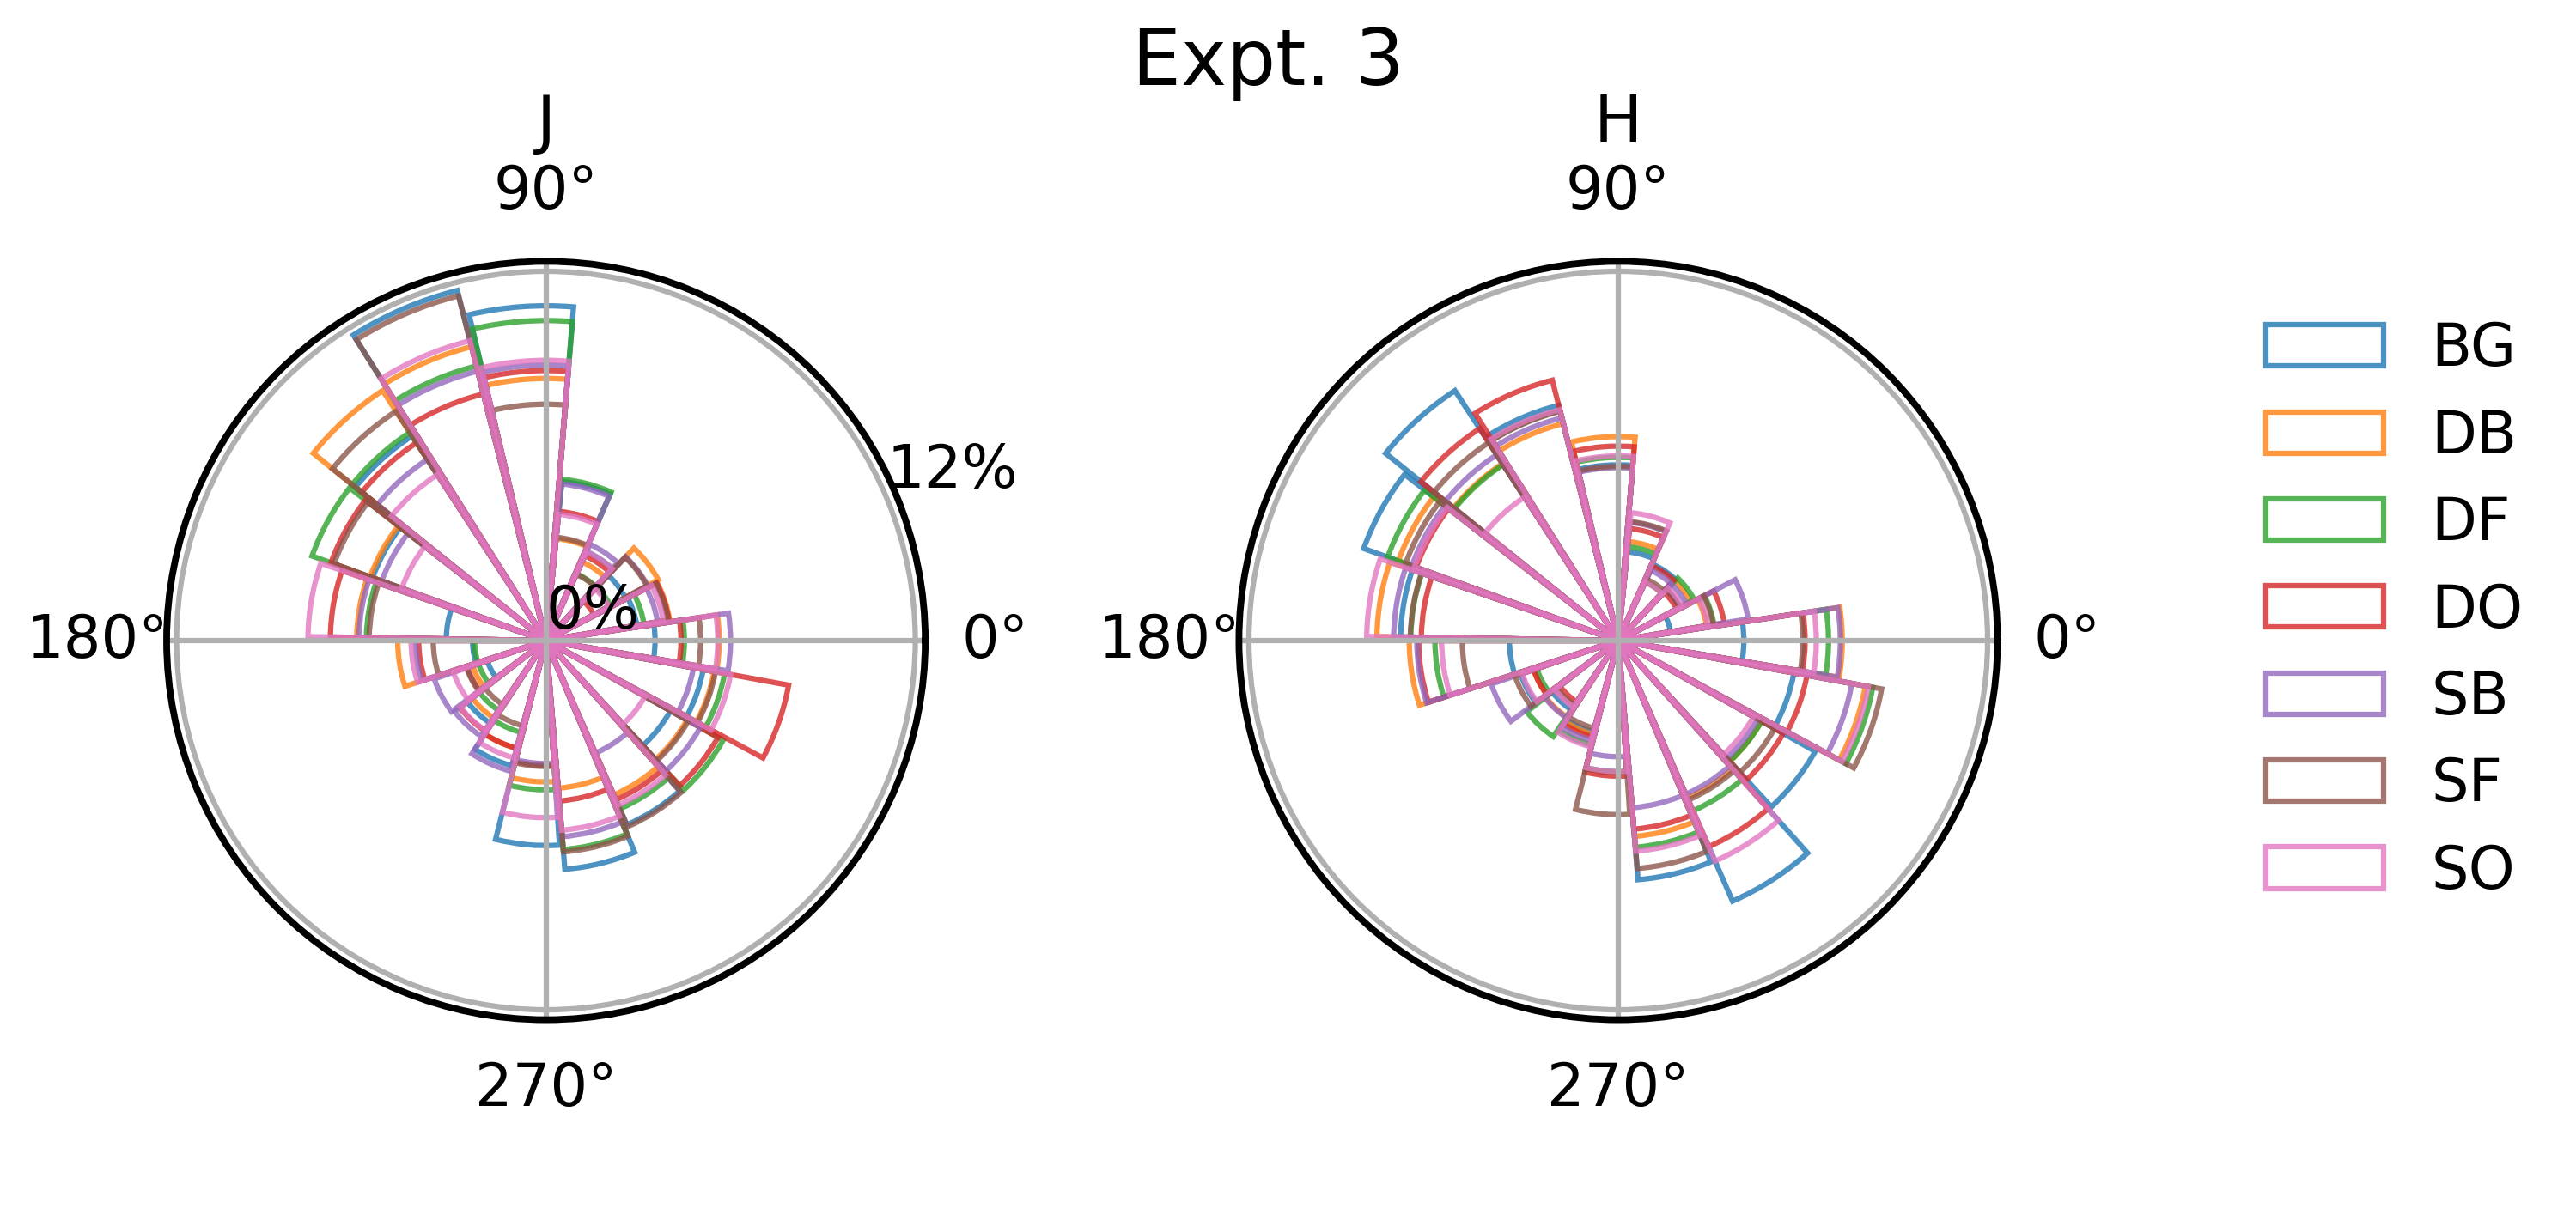

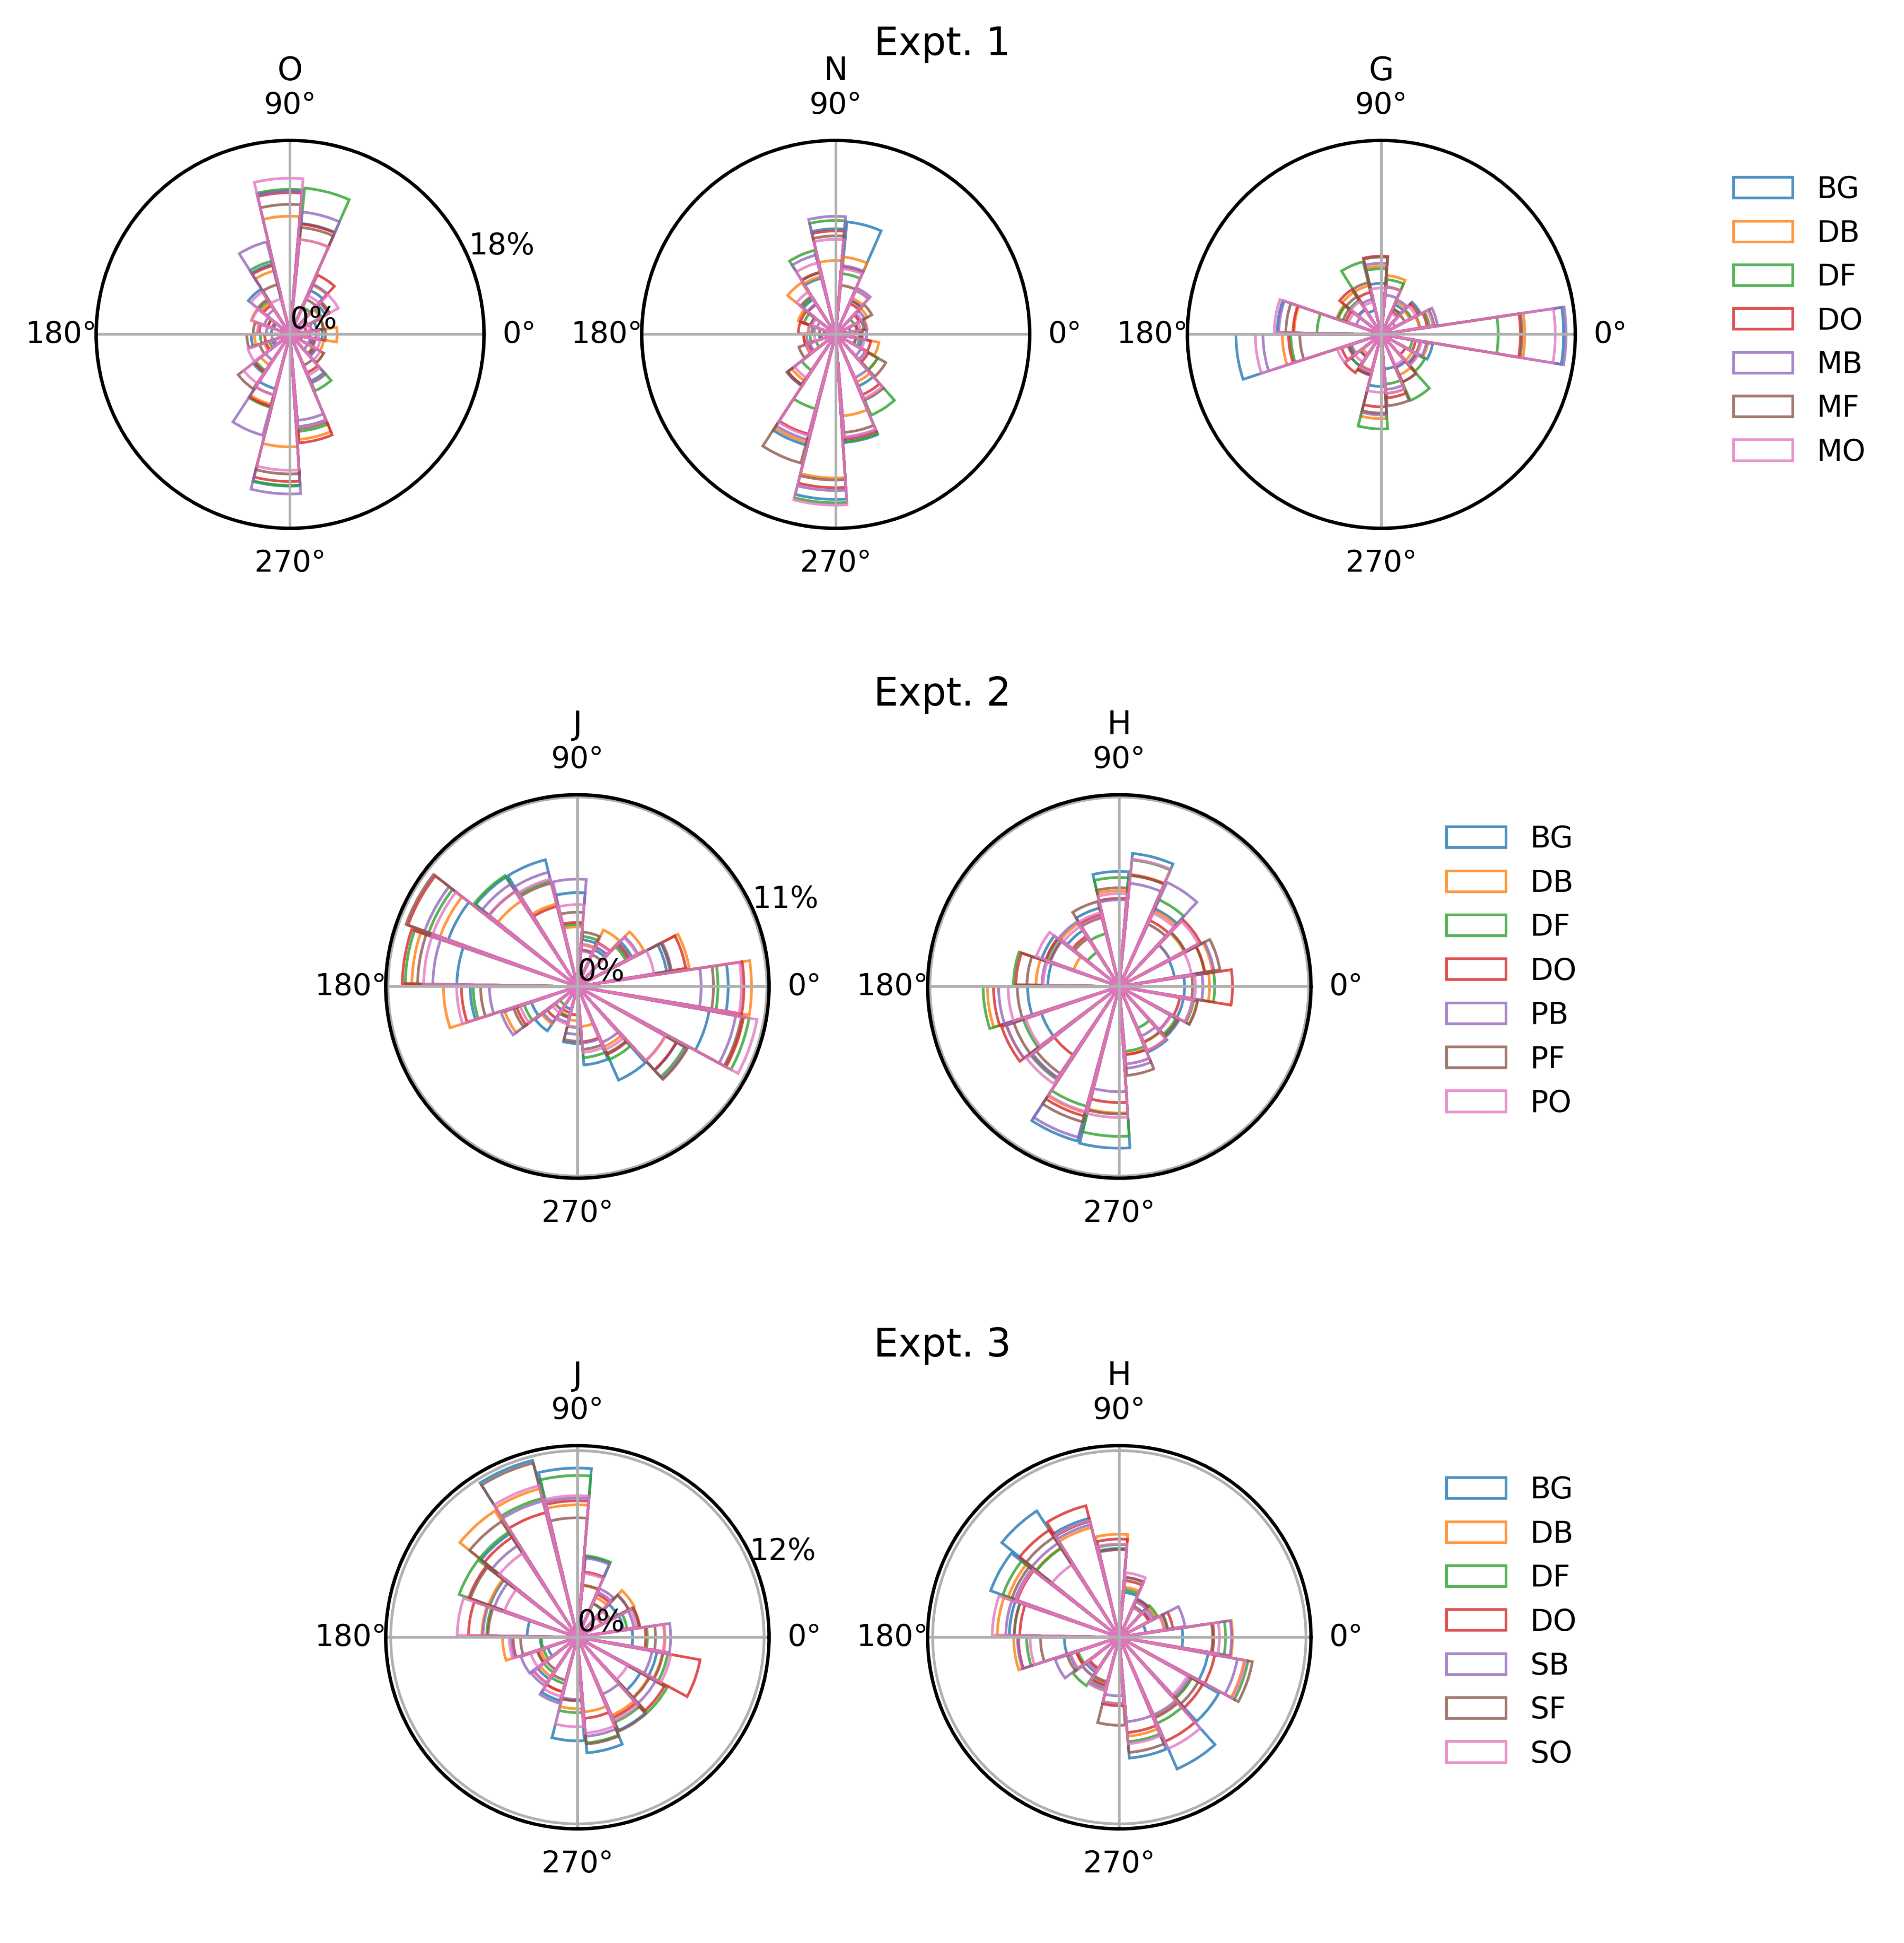

In [ ]:
df_scdata_cl_exp1 = df_SCdata_cl[df_SCdata_cl.exp_name == 'Expt. 1']
df_scdata_cl_exp2 = df_SCdata_cl[df_SCdata_cl.exp_name == 'Expt. 2']
df_scdata_cl_exp3 = df_SCdata_cl[df_SCdata_cl.exp_name == 'Expt. 3']

# plot the facetgrid for each experiment
gd1 = plotSaccadir(df_scdata_cl_exp1)
gd2 = plotSaccadir(df_scdata_cl_exp2)
gd3 = plotSaccadir(df_scdata_cl_exp3)

# concatenate all the plots in a single figure using matplotlib.image as mpimg
fig, axarr = plt.subplots(3, 1, figsize=(25, 16))
axarr[0].imshow(mpimg.imread(plot_path / 'saccade_dir_Expt. 1.png'))
axarr[1].imshow(mpimg.imread(plot_path / 'saccade_dir_Expt. 2.png'))
axarr[2].imshow(mpimg.imread(plot_path / 'saccade_dir_Expt. 3.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]

plt.tight_layout()
plt.show()
fig.savefig(plot_path / 'saccade_dir.png')

### 7. Velocity Plot
- requires `df_all`
- plots the gaussian filterd velocity data
- std = 2 (8.33*2 ms)

In [ ]:
def ploVelocity(df_vel_hist):
    # condt_order, mnk_order = fix_order(df_vel_hist)
    # mnk_order = df_vel_hist.monkey.unique().tolist()
    if df_vel_hist.exp_name.unique()[0] == 'Expt. 1':
        mnk_order = ['O', 'N', 'G']
    else:
        mnk_order = ['J', 'H']

    fg = sns.relplot(data=df_vel_hist, x='vel_flt_mid', y='count', hue='direct.',
    col='monkey',col_order=mnk_order,  height=5,
    aspect=1, style='condit.',facet_kws={'margin_titles': True},
    linewidth=1, dashes=True, kind='line')

    fg.set_axis_labels('speed ($\degree$/s)', 'relative freq.(%)')
    fg.set_titles(row_template='{row_name}', col_template='{col_name}')
    fg.legend.set_title(None)
    fg.fig.suptitle(f'{df_vel_hist.exp_name.unique()[0]}')

    fg.tight_layout()
    fg.savefig(plot_path / f'speed_{df_vel_hist.exp_name.unique()[0]}.png')
    return fg
# remove column and row titles

In [ ]:
# velocity data
df_vel = df_all[['monkey', 'condt', 'exp_name', 'xvel_flt', 'yvel_flt']].melt(
    id_vars=['monkey', 'condt', 'exp_name'], value_vars=['xvel_flt', 'yvel_flt'], var_name='vel', value_name='vel_flt')
df_vel.replace({'xvel_flt': 'hor.', 'yvel_flt': 'ver.'}, inplace=True)

# geting nomralized histogram of velocity
bins = np.linspace(0, 50, 100)
df_vel_hist = df_vel.groupby(['exp_name', 'monkey', 'condt', 'vel', pd.cut(df_vel.vel_flt.abs(), bins)]).count()
df_vel_hist.rename(columns={'vel_flt': 'count'}, inplace=True)
df_vel_hist.reset_index(inplace=True)
df_vel_hist['vel_flt_mid'] = df_vel_hist['vel_flt'].apply(lambda x: x.mid).astype(float)
def norm_hist(df, col):
    df = df.copy()
    df['count'] = (df['count']/df['count'].sum())*100
    return df
df_vel_hist = df_vel_hist.groupby(['exp_name', 'monkey', 'condt', 'vel']).apply(norm_hist, 'count')
## remove colummns with nan values
df_vel_hist.dropna(inplace=True)
df_vel_hist.rename(columns={'vel': 'direct.', 'condt': 'condit.'}, inplace=True)

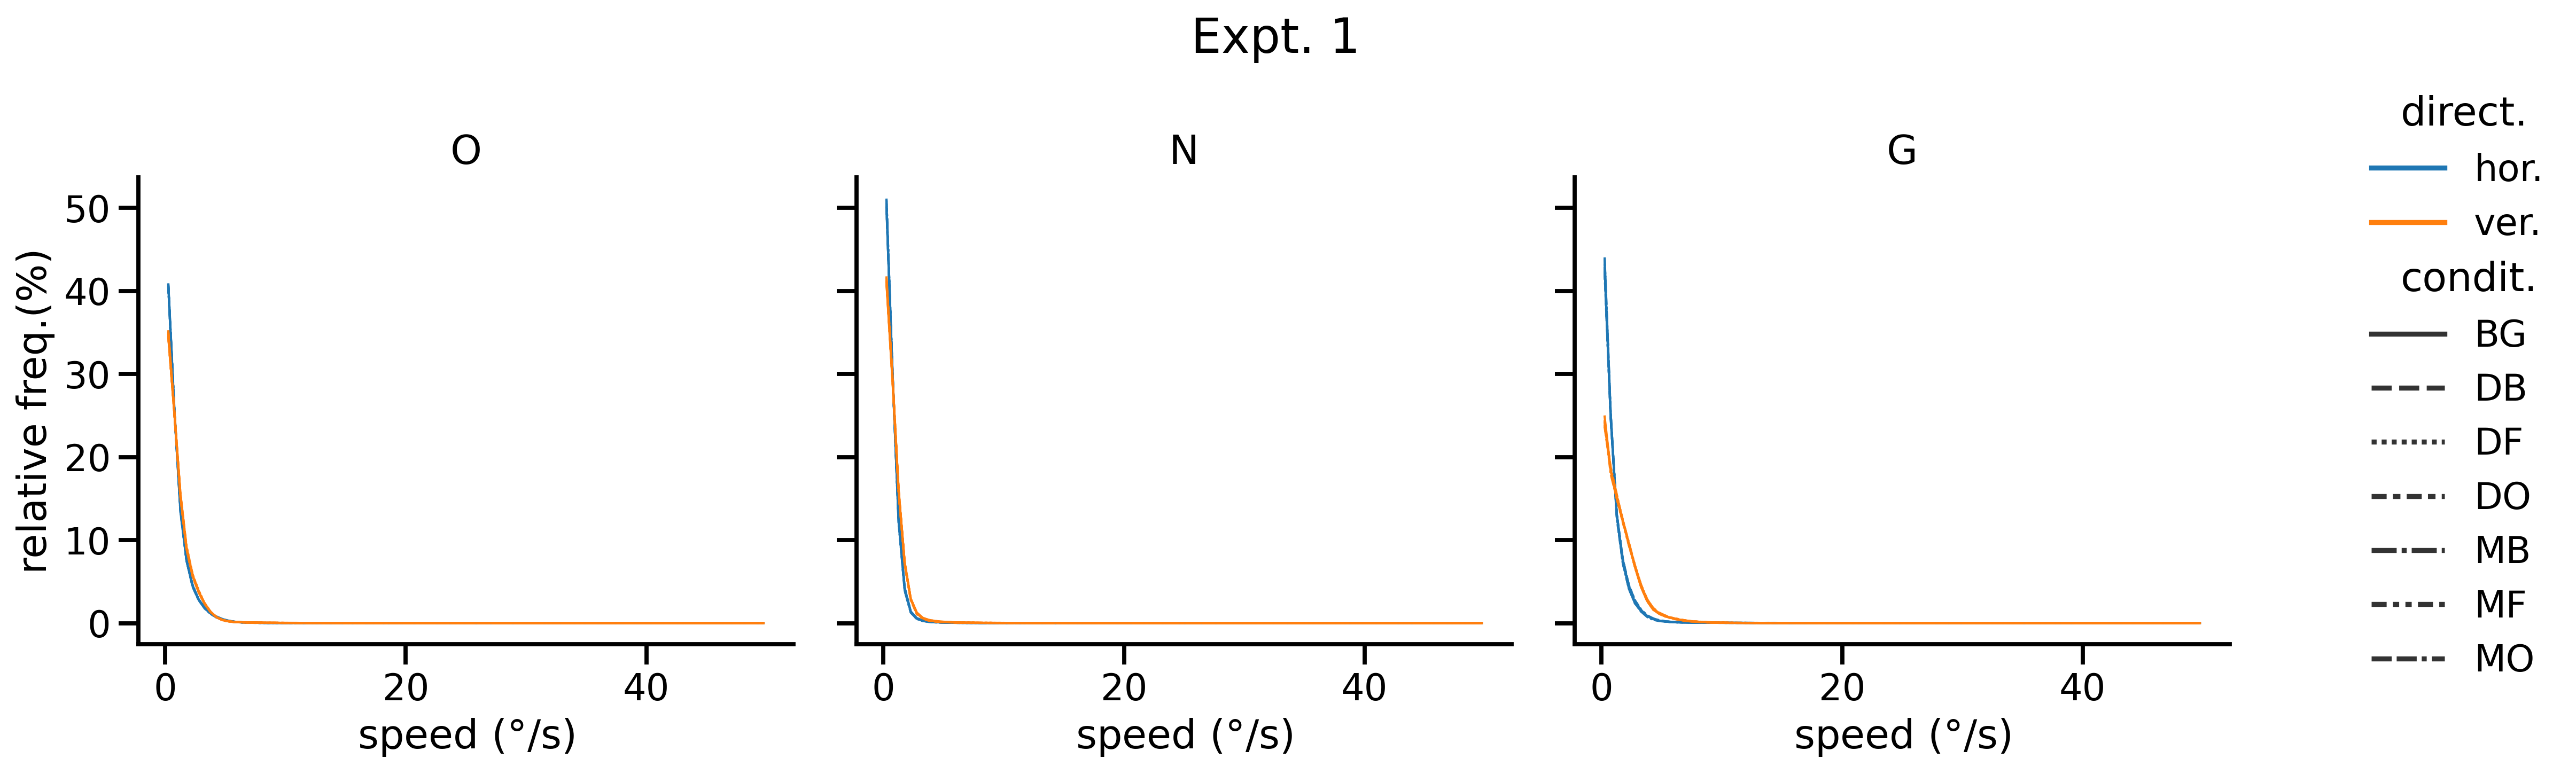

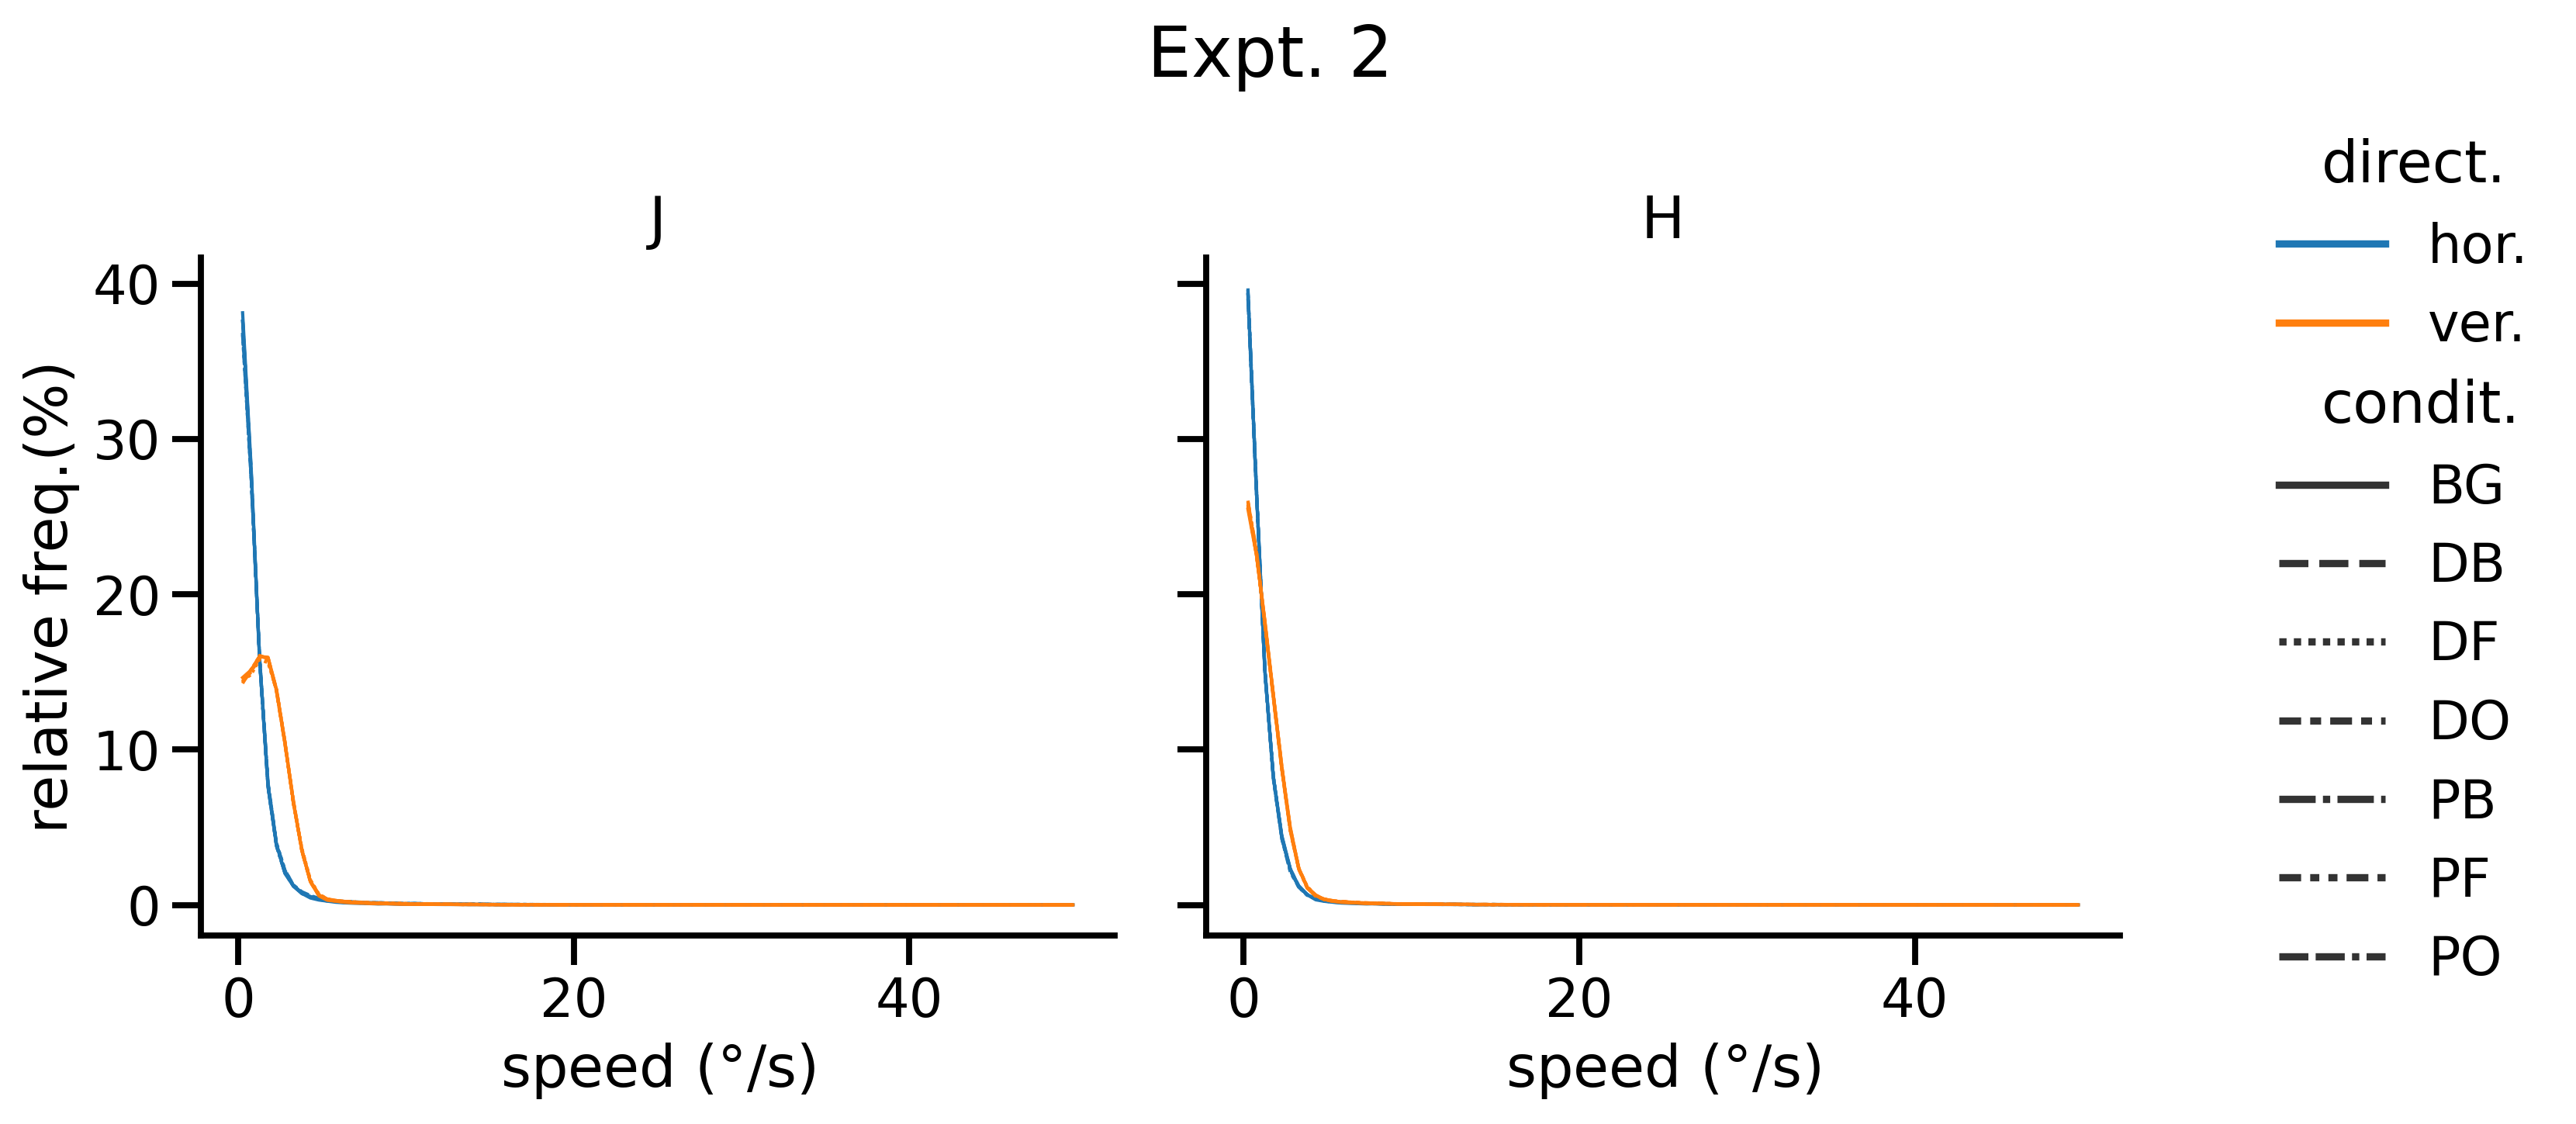

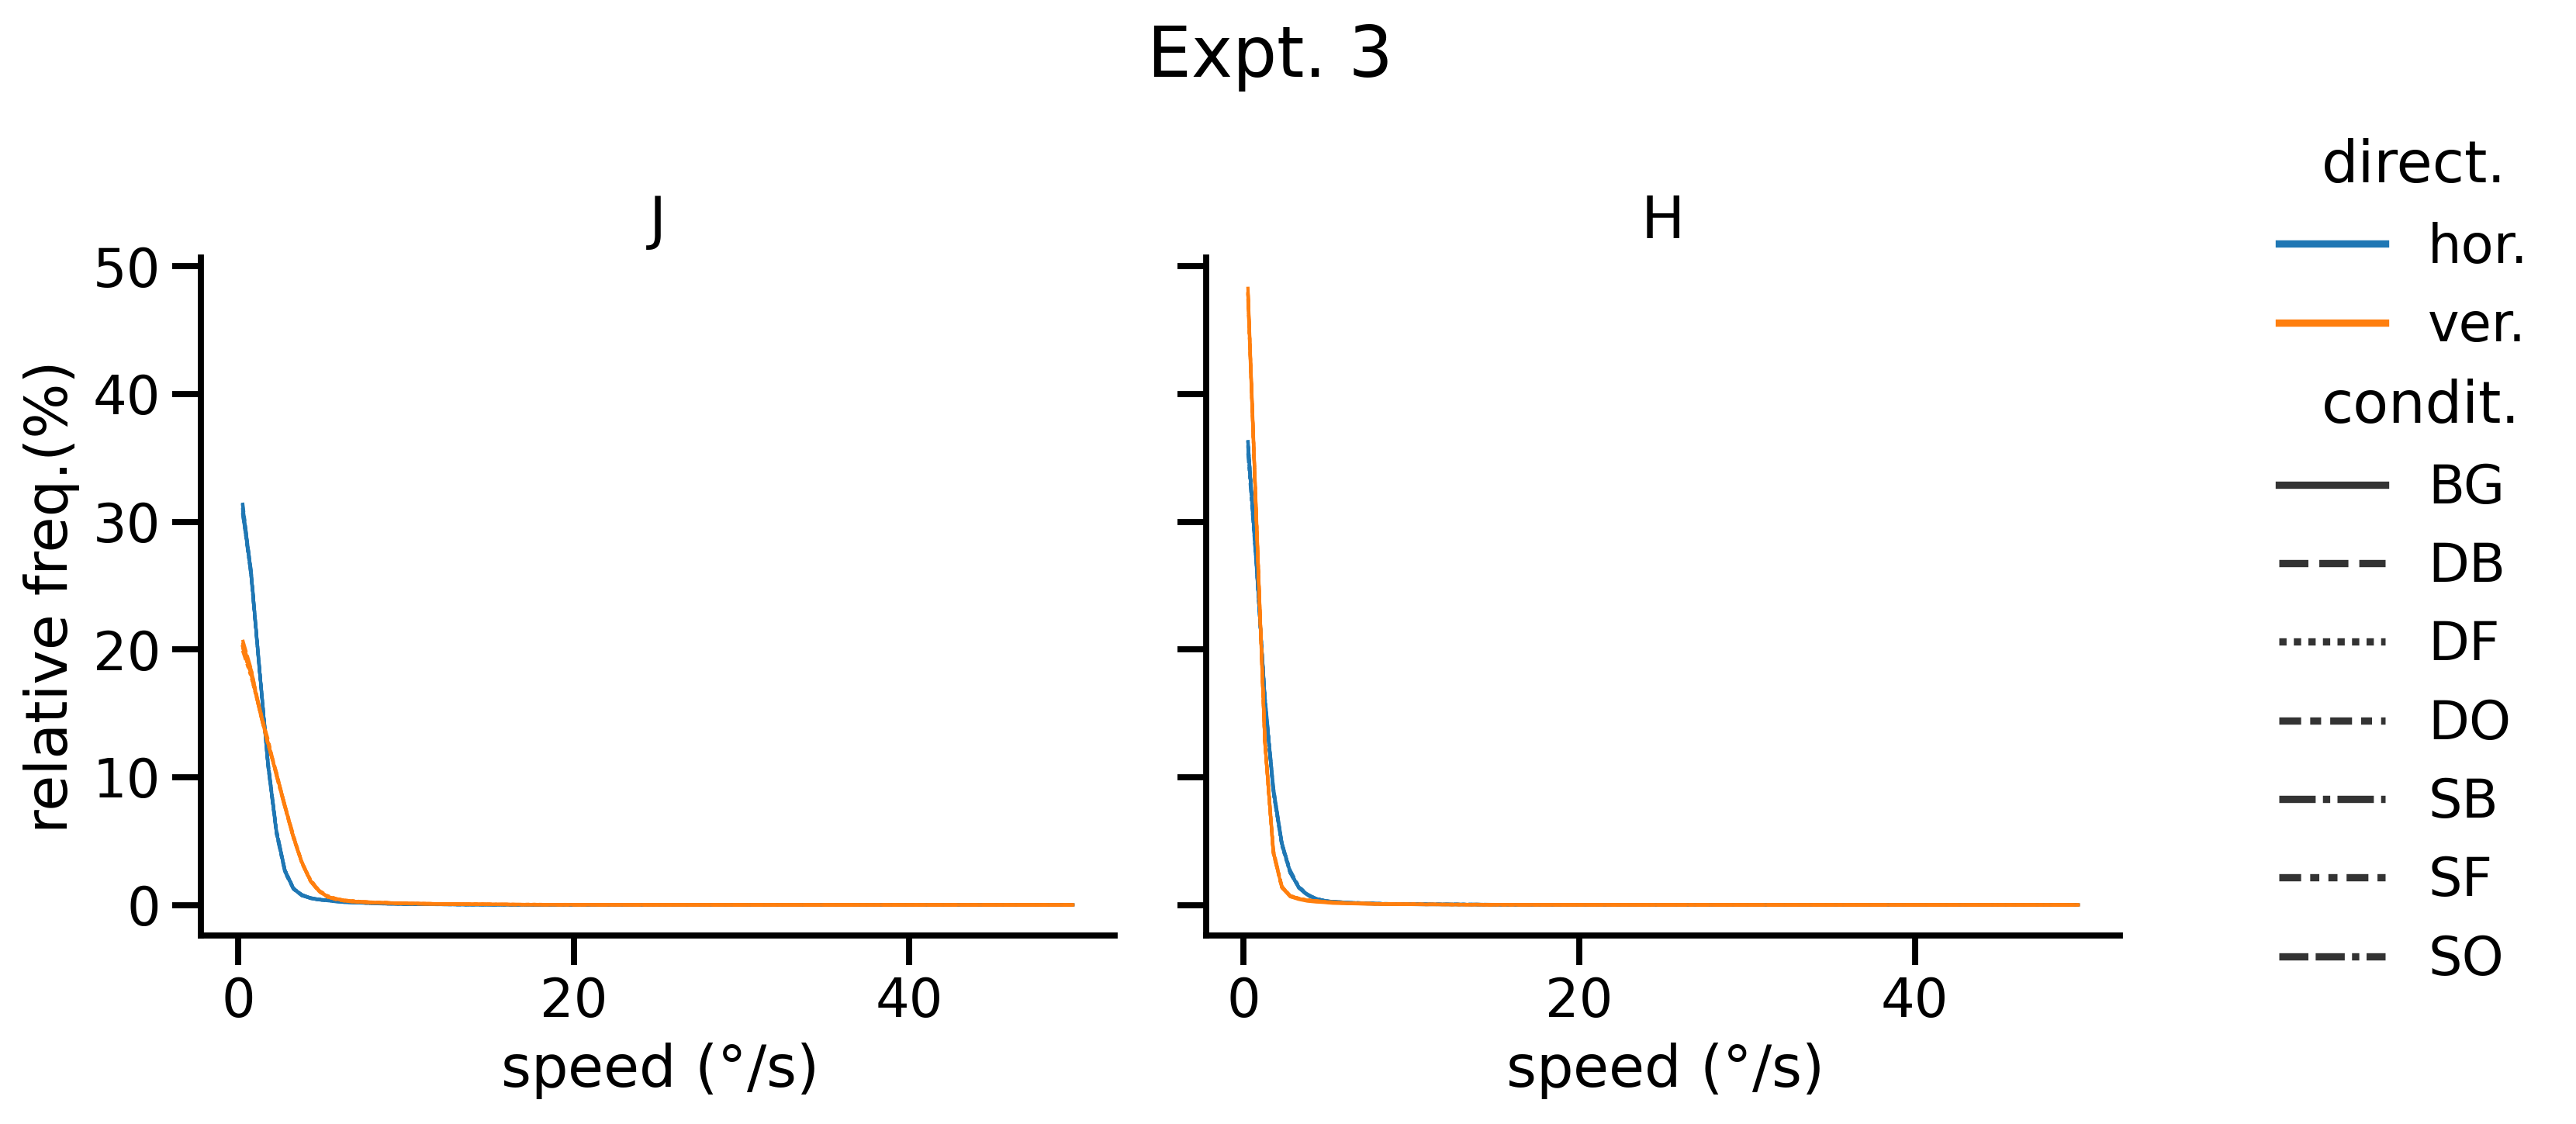

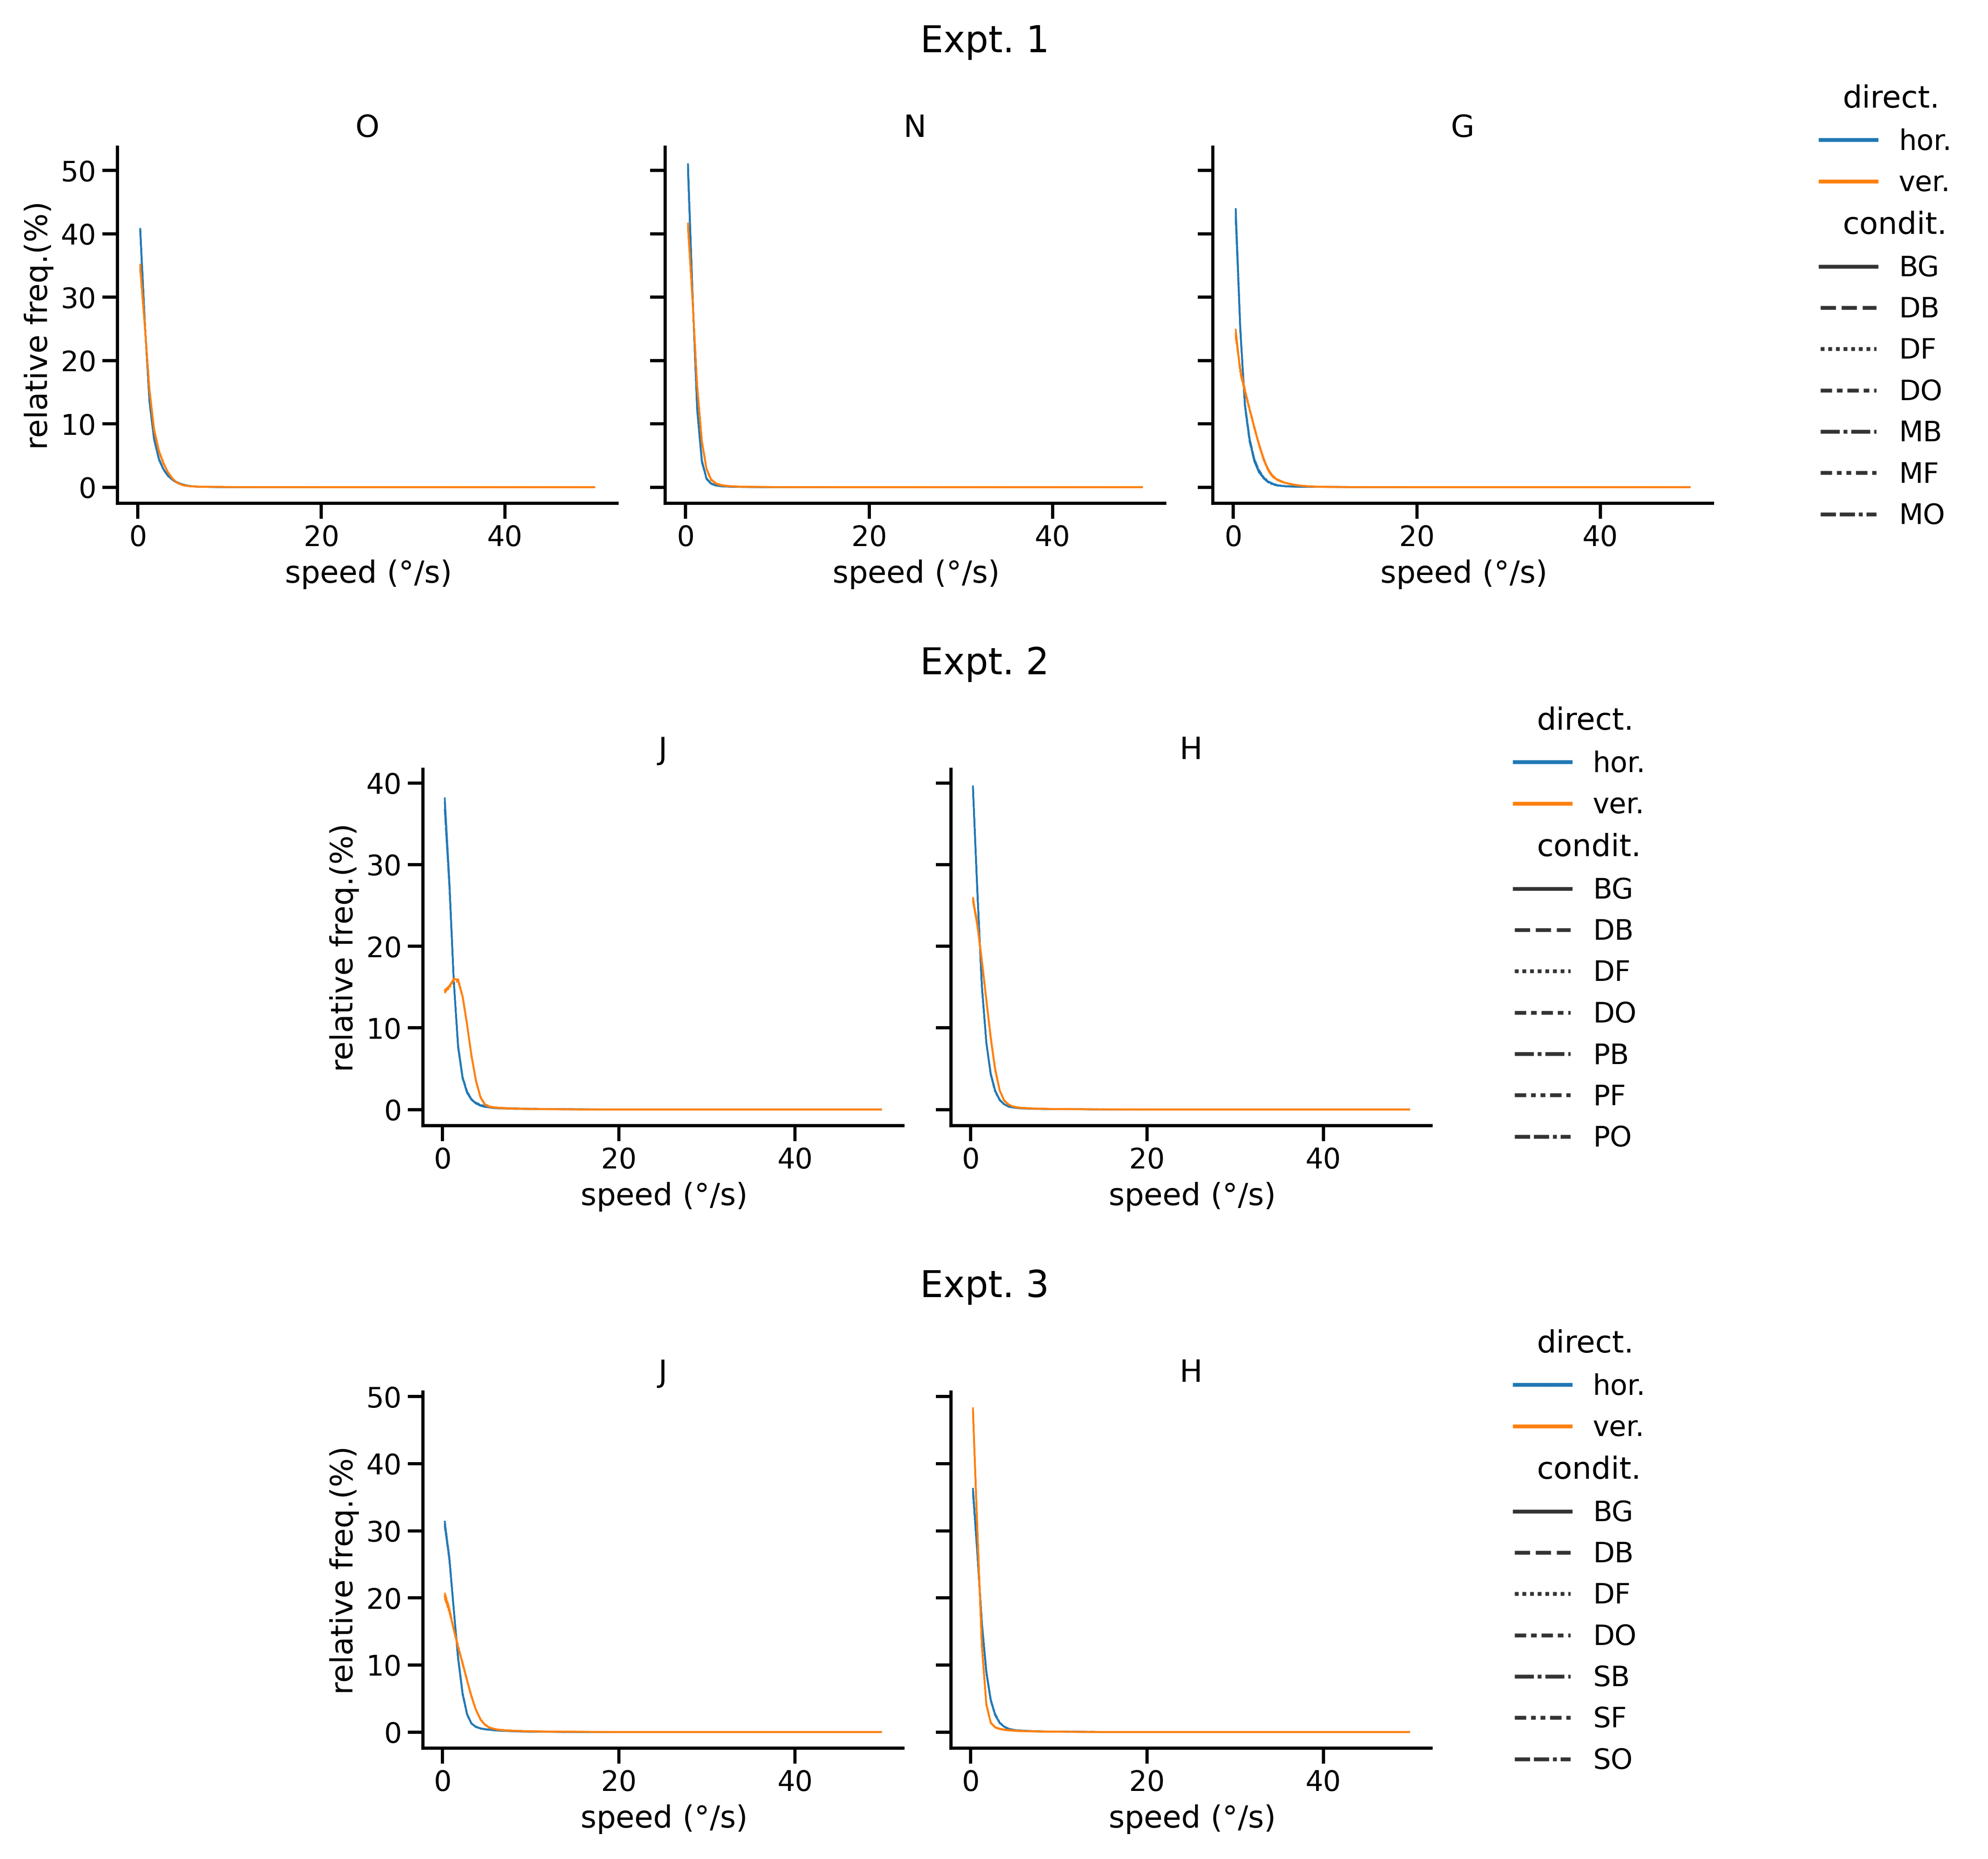

In [ ]:
# plot velocity for each experiment
df_vel_hist_exp1 = df_vel_hist[df_vel_hist.exp_name == 'Expt. 1']
df_vel_hist_exp2 = df_vel_hist[df_vel_hist.exp_name == 'Expt. 2']
df_vel_hist_exp3 = df_vel_hist[df_vel_hist.exp_name == 'Expt. 3']

g1 = ploVelocity(df_vel_hist_exp1)
g2 = ploVelocity(df_vel_hist_exp2)
g3 = ploVelocity(df_vel_hist_exp3)

# concatenate all plots using matplotlib mpimg
fig, axarr = plt.subplots(3, 1, figsize=(25, 16))
axarr[0].imshow(mpimg.imread(plot_path / 'speed_Expt. 1.png'))
axarr[1].imshow(mpimg.imread(plot_path / 'speed_Expt. 2.png'))
axarr[2].imshow(mpimg.imread(plot_path / 'speed_Expt. 3.png'))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()
plt.show()
fig.savefig(plot_path / 'speed.png')

In [ ]:
# remove all experiment specific plots
expt_figs = plot_path.glob('*Expt*.png')
for fig in expt_figs:
    fig.unlink()